# Введение

## Прогноз спроса

**Источник**: https://sibur.ai-community.com/

**Описание:**
СИБУР производит и продает различную нефтехимическую продукцию во многие страны мира. Поэтому прогноз спроса необходимо строить с детализацией до продукта, региона, клиента и менеджера, осуществляющего сделку.

Для построения модели даны сделки за тренировочный период (с 2018-01-01 по 2020-07-31) с полями, описывающими сделку. Тестовый набор данных соответствует периоду с 2020-08-01 по 2021-07-31.

**Задача:** предсказать суммарный объем для следующего месяца для каждой группы (всего 941 группа: `material_code`, `company_code`, `country`, `region`, `manager_code`).

**Метрика:** RMSLE 

[What’s the Difference Between RMSE and RMSLE?](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)

## Структура данных

Поля в наборе данных:

   + *material_code* - код продукта,
   + *company_code* - код клиента, который всегда равен 0 для спотовых сделок,
   + *country* - страна, в которую осуществляется продажа,
   + *region* - регион внутри страны, в которую осуществляется продажа; для большинства стран не детализирован,
   + *manager_code* - код менеджера, ведущего сделку,
   + *month* - месяц сделки,
   + *material_lvl1_name*, *material_lvl2_name*, *material_lvl3_name* - группировка продукта по категориям разных уровней,
   + *contract_type* - тип сделки,
   + *date* - точная дата сделки,
   + *volume* - объем сделки.


## Оглавление

+ [1 Загрузка библиотек](#1-Загрузка-библиотек)

+ [2 Загрузка данных](#2-Загрузка-данных)

+ [3 Предподготовка данных](#3-Предподготовка-данных)

   + [3.1 Формирование вспомогательных таблиц](#3.1-Формирование-вспомогательных-таблиц)
   
   + [3.2 Исследование данных](#3.2-Исследование-данных)
   
   + [3.3 Целевая переменная](#3.3-Целевая-переменная)
   
      + [3.3.1 Распределение](#3.3.1-Распределение)
      
      + [3.3.2 Автокорреляция](#3.3.2-Автокорреляция)
   
   + [3.4 Редкий хаотичный спрос](#3.4-Редкий-хаотичный-спрос)
   
+ [4 Генерация признаков](#4-Генерация-признаков)

   + [4.1 Внутригрупповые признаки](#4.1-Внутригрупповые-признаки)
   
   + [4.2 Внешнегрупповые признаки](#4.2-Внешнегрупповые-признаки)
   
   + [4.3 Контрактные признаки](#4.3-Контрактные-признаки)
   
      + [4.3.1 Частота сделок](#4.3.1-Частота-сделок)
      
      + [4.3.2 Последняя сделка](#4.3.2-Последняя-сделка)
      
   + [4.4 Создание всех признаков](#4.4-Создание-всех-признаков) 
   
+ [5 Трансформация и анализ признаков](#5-Трансформация-и-анализ-признаков)  

   + [5.1 One hot encoding](#5.1-One-hot-encoding)
   
   + [5.2 Матрица корреляций](#5.2-Матрица-корреляций)
   
+ [6 Моделирование](#6-Моделирование)  

   + [6.1 Сравнение моделей](#6.1-Сравнение-моделей)
   
   + [6.2 CatBoostRegressor](#6.2-CatBoostRegressor)
   
     + [6.2.1 Обучение](#6.2.1-Обучение)
   
     + [6.2.2 Feature selection](#6.2.2-Feature-selection)
     
     + [6.2.3 Подбор гиперпараметров](#6.2.3-Подбор-гиперпараметров)
   
   + [6.3 LGBMRegressor](#6.3-LGBMRegressor)
   
   + [6.4 RandomForestRegressor](#6.4-RandomForestRegressor)
   
   + [6.5 Ridge](#6.5-Ridge)
   
   + [6.6 Стекинг](#6.6-Стекинг)
   
+ [7 Формирование загрузки](#7-Формирование-загрузки) 
+ [Результат](#Результат)

# 1 Загрузка библиотек 

In [1]:
# основные
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# вспомогательные
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import shap
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from eli5.sklearn import PermutationImportance

# модели
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

# прочие
import pathlib
import pickle
from tqdm.notebook import tqdm
from zipfile import ZipFile
import warnings

## Настройка окружения

In [2]:
# фильтр ошибок
warnings.filterwarnings('ignore')

# графики
plt.style.use('seaborn')

plt.rc(
    "axes",
    labelweight="bold",
    labelsize=14,
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)

plt.rc('ytick', labelsize=13,)
plt.rc('xtick', labelsize=13,)
plt.rc('legend', fontsize=13)

# 2 Загрузка данных

[Pathlib — манипуляция путями, создание и удаление папок и файлов](https://python-scripts.com/pathlib)

In [3]:
DATA_DIR = pathlib.Path(".")
DATA_FILE = "sc2021_train_deals.csv"
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]
MATERIALS = ['material_lvl1_name', 'material_lvl2_name']
RS = 82736

In [4]:
data = pd.read_csv(DATA_DIR / DATA_FILE, parse_dates=["month", "date"], infer_datetime_format=True)
data.head()

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,date,volume
0,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-01,43.0
1,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,95.0
2,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-02,57.0
3,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,21.0
4,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,150.0


In [5]:
print('Начало периода:', data.month.min())
print('Конец периода:', data.month.max())

Начало периода: 2018-01-01 00:00:00
Конец периода: 2020-07-01 00:00:00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92306 entries, 0 to 92305
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   material_code       92306 non-null  int64         
 1   company_code        92306 non-null  int64         
 2   country             92306 non-null  object        
 3   region              92306 non-null  object        
 4   manager_code        92306 non-null  int64         
 5   month               92306 non-null  datetime64[ns]
 6   material_lvl1_name  92306 non-null  object        
 7   material_lvl2_name  92306 non-null  object        
 8   material_lvl3_name  92306 non-null  object        
 9   contract_type       92306 non-null  object        
 10  date                92306 non-null  datetime64[ns]
 11  volume              92306 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 8.5+ MB


In [7]:
# количество уникальных значений в каждой колонке
data.nunique()

material_code          90
company_code          229
country                30
region                102
manager_code           59
month                  31
material_lvl1_name      3
material_lvl2_name      5
material_lvl3_name      5
contract_type           3
date                  943
volume                393
dtype: int64

# 3 Предподготовка данных

## 3.1 Формирование вспомогательных таблиц

### df_general

Общая таблица сгруппированная по предсказательным группам, учитывающая материал.
+ Наименование материала 3 уровня исключили, так как он повторяет наименование 2 уровня
+ В каждой группе уникальный материл, поэтому его включили в группировку

[Reshaping in Pandas with stack() and unstack() Functions](https://medium.com/swlh/reshaping-in-pandas-with-stack-and-unstack-functions-bb169f64467d)

In [8]:
# проверка на равенство таблиц
for name2, name3 in zip(data['material_lvl2_name'].unique(), data['material_lvl3_name'].unique()):
    equals = data[data['material_lvl3_name'] == name3].equals(data[data['material_lvl2_name'] == name2])
    print(f'{name2} = {name3}: {equals}')

ПЭ = ПЭНП: True
ПП = ПП: True
ПСВ = Полистирол: True
ТЭП = Термоэластопласты: True
Гликоли = МЭГ: True


In [9]:
df_general = data.groupby(AGG_COLS + MATERIALS + ["month"])['volume'].sum().unstack(fill_value=0).reset_index()
df_general.head()

month,material_code,company_code,country,region,manager_code,material_lvl1_name,material_lvl2_name,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,...,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00
0,124,7278,Россия,Респ. Татарстан,17460,Базовые полимеры,ПЭ,340.0,340.0,260.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,133,0,Белоруссия,Минская обл.,10942,Базовые полимеры,ПЭ,0.0,0.0,0.0,...,181.0,208.0,207.0,17.0,72.0,250.0,394.0,288.0,210.0,249.0
2,133,0,Белоруссия,Могилевская обл.,10942,Базовые полимеры,ПЭ,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,166.0,62.0,0.0,0.0
3,133,0,Белоруссия,г. Минск,10942,Базовые полимеры,ПЭ,0.0,20.0,0.0,...,82.0,42.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,6.0
4,133,0,Казахстан,г. Нур-Султан,13301,Базовые полимеры,ПЭ,0.0,0.0,30.0,...,45.0,50.0,45.0,0.0,50.0,40.0,0.0,0.0,50.0,0.0


### df_features

Основа для будущих признаков. К ней далее будем присоединять дополнительные фичи

In [10]:
df_features = df_general[AGG_COLS + MATERIALS]
df_features.head()

month,material_code,company_code,country,region,manager_code,material_lvl1_name,material_lvl2_name
0,124,7278,Россия,Респ. Татарстан,17460,Базовые полимеры,ПЭ
1,133,0,Белоруссия,Минская обл.,10942,Базовые полимеры,ПЭ
2,133,0,Белоруссия,Могилевская обл.,10942,Базовые полимеры,ПЭ
3,133,0,Белоруссия,г. Минск,10942,Базовые полимеры,ПЭ
4,133,0,Казахстан,г. Нур-Султан,13301,Базовые полимеры,ПЭ


### df_target

Целевая переменная:
+ колонки - месяцы
+ строки - группы

In [11]:
df_target = df_general.select_dtypes('float')
df_target.tail()

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,...,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01
936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,21.0,63.0,125.0,84.0,84.0,83.0
937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,5.0,...,10.0,0.0,6.0,5.0,5.0,5.0,0.0,3.0,3.0,9.0
938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.0,102.0,29.0,73.0,74.0,122.0,100.0,15.0,30.0,50.0
939,60.0,60.0,100.0,60.0,60.0,80.0,80.0,100.0,80.0,80.0,...,120.0,140.0,100.0,100.0,180.0,180.0,100.0,140.0,40.0,0.0
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,40.0,40.0,40.0,0.0,20.0,40.0,20.0,21.0,21.0


### df_contract

Таблица учитывающая количество контрактов каждого типа

In [12]:
df_contract = data.groupby(AGG_COLS+['contract_type']+['month']).size()\
                  .unstack(['contract_type']+['month'], fill_value=0)\
                  
df_contract.tail()

contract_type                                                      Contract + Spot  \
month                                                                   2018-01-01   
material_code company_code country region             manager_code                   
986           9943         Россия  Смоленская обл.    17460                      0   
998           0            Россия  Ленинградская обл. 18079                      0   
              3380         Россия  Ленинградская обл. 14956                      0   
              5410         Россия  г. Санкт-Петербург 14956                      0   
              6346         Россия  Респ. Башкортостан 10737                      0   

contract_type                                                                  \
month                                                              2018-02-01   
material_code company_code country region             manager_code              
986           9943         Россия  Смоленская обл.    17460                 0   
998           0            Россия  Ленинградская обл. 18079                 0   
              3380         Россия  Ленинградская обл. 14956                 0   
              5410         Россия  г. Санкт-Петербург 14956                 0   
              6346         Россия  Респ. Башкортостан 10737                 0   

contract_type                                                                  \
month                                                              2018-03-01   
material_code company_code country region             manager_code              
986           9943         Россия  Смоленская обл.    17460                 0   
998           0            Россия  Ленинградская обл. 18079                 0   
              3380         Россия  Ленинградская обл. 14956                 0   
              5410         Россия  г. Санкт-Петербург 14956                 0   
              6346         Россия  Респ. Башкортостан 10737                 0   

contract_type                                                                  \
month                                                              2018-04-01   
material_code company_code country region             manager_code              
986           9943         Россия  Смоленская обл.    17460                 0   
998           0            Россия  Ленинградская обл. 18079                 0   
              3380         Россия  Ленинградская обл. 14956                 0   
              5410         Россия  г. Санкт-Петербург 14956                 0   
              6346         Россия  Респ. Башкортостан 10737                 0   

contract_type                                                                  \
month                                                              2018-05-01   
material_code company_code country region             manager_code              
986           9943         Россия  Смоленская обл.    17460                 0   
998           0            Россия  Ленинградская обл. 18079                 0   
              3380         Россия  Ленинградская обл. 14956                 0   
              5410         Россия  г. Санкт-Петербург 14956                 0   
              6346         Россия  Респ. Башкортостан 10737                 0   

contract_type                                                                  \
month                                                              2018-06-01   
material_code company_code country region             manager_code              
986           9943         Россия  Смоленская обл.    17460                 0   
998           0            Россия  Ленинградская обл. 18079                 0   
              3380         Россия  Ленинградская обл. 14956                 0   
              5410         Россия  г. Санкт-Петербург 14956                 0   
              6346         Россия  Респ. Башкортостан 10737                 0   

contract_type                                                     

### df_date

Далее поможет определить количество дней от последней сделки до текущего месяца

In [13]:
df_date = data.groupby(AGG_COLS+['month']+['date'])['volume'].sum().unstack(['month', 'date'], fill_value=0)
df_date.head()

month                                                               2018-01-01  \
date                                                                2018-01-09   
material_code company_code country    region           manager_code              
124           7278         Россия     Респ. Татарстан  17460              60.0   
133           0            Белоруссия Минская обл.     10942               0.0   
                                      Могилевская обл. 10942               0.0   
                                      г. Минск         10942               0.0   
                           Казахстан  г. Нур-Султан    13301               0.0   

month                                                                           \
date                                                                2018-01-10   
material_code company_code country    region           manager_code              
124           7278         Россия     Респ. Татарстан  17460              20.0   
133           0            Белоруссия Минская обл.     10942               0.0   
                                      Могилевская обл. 10942               0.0   
                                      г. Минск         10942               0.0   
                           Казахстан  г. Нур-Султан    13301               0.0   

month                                                                           \
date                                                                2018-01-12   
material_code company_code country    region           manager_code              
124           7278         Россия     Респ. Татарстан  17460              60.0   
133           0            Белоруссия Минская обл.     10942               0.0   
                                      Могилевская обл. 10942               0.0   
                                      г. Минск         10942               0.0   
                           Казахстан  г. Нур-Султан    13301               0.0   

month                                                                           \
date                                                                2018-01-17   
material_code company_code country    region           manager_code              
124           7278         Россия     Респ. Татарстан  17460              40.0   
133           0            Белоруссия Минская обл.     10942               0.0   
                                      Могилевская обл. 10942               0.0   
                                      г. Минск         10942               0.0   
                           Казахстан  г. Нур-Султан    13301               0.0   

month                                                                           \
date                                                                2018-01-18   
material_code company_code country    region           manager_code              
124           7278         Россия     Респ. Татарстан  17460              20.0   
133           0            Белоруссия Минская обл.     10942               0.0   
                                      Могилевская обл. 10942               0.0   
                                      г. Минск         10942               0.0   
                           Казахстан  г. Нур-Султан    13301               0.0   

month                                                                           \
date                                                                2018-01-19   
material_code company_code country    region           manager_code              
124           7278         Россия     Респ. Татарстан  17460              40.0   
133           0            Белоруссия Минская обл.     10942               0.0   
                                      Могилевская обл. 10942               0.0   
                                      г. Минск         10942               0.0   
                           Казахстан  г. Нур-Султан    13301               0.0   

month                                                     

Итого получили 5 вспомогательных таблиц

## 3.2 Исследование данных

### Регион

In [14]:
df_general['region'].value_counts()

Московская обл.                108
г. Санкт-Петербург              40
Ростовская обл.                 38
Новосибирская обл.              34
Китай                           34
                              ... 
Словакия                         1
Восточно-Казахстанская обл.      1
Калининградская обл.             1
Павлодарская обл.                1
Атырауская обл.                  1
Name: region, Length: 102, dtype: int64

In [15]:
region_largest = df_general['region'].value_counts().index[:10]
region_smallest = df_general['region'].value_counts(ascending=True).index[:10]

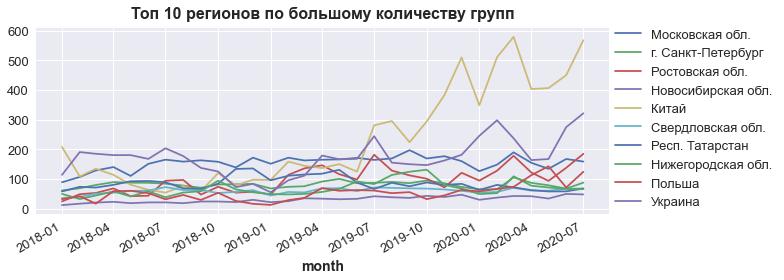

In [16]:
month_range = pd.date_range('2018-01-01', '2020-07-01', freq='MS')
month = pd.Timestamp('2020-04-01')
region_mean = df_general.groupby('region')[month_range].mean()
region_mean.loc[region_largest].T.plot(title='Топ 10 регионов по большому количеству групп').legend(loc=(1, 0))
plt.show()

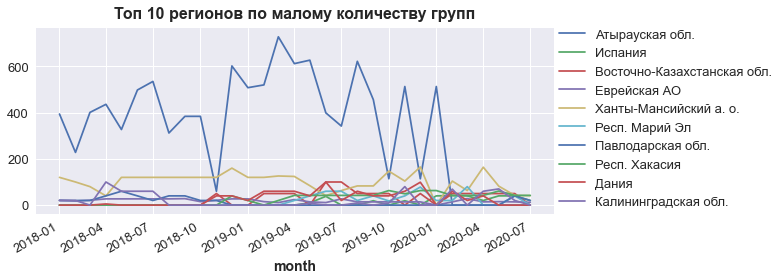

In [17]:
region_mean.loc[region_smallest].T.plot(title='Топ 10 регионов по малому количеству групп').legend(loc=(1, 0))
plt.show()

### Страна

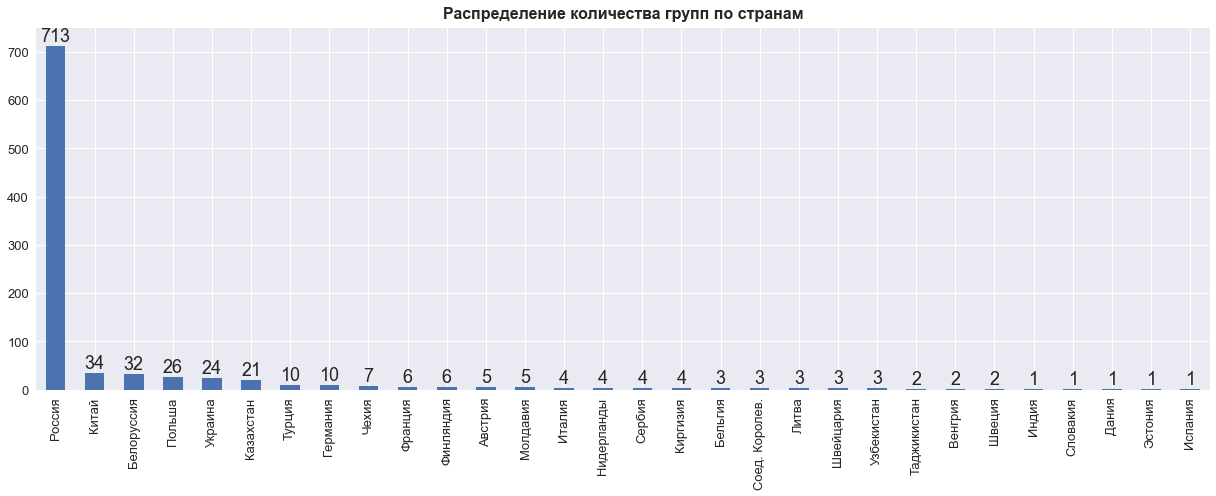

In [18]:
plt.figure(figsize=(17, 7))
df_general['country'].value_counts().plot(kind='bar', title='Распределение количества групп по странам')
for i, count in enumerate(df_general['country'].value_counts()):
    plt.text(i, count+10, count, ha='center', size=18)
plt.show()

+ Много из России, можно создать флаг для нее. (сделки внутри страны и за предлами)
+ Выделить страны Евросоюза, СНГ, Азии
+ ~~(Выделить по экономическому типу)~~

In [19]:
Asia = ['Китай', 'Индия', 'Турция']
Europe = ['Испания', 'Эстония', 'Дания', 'Словакия', 'Швеция', 'Венгрия', 'Швейцария', 'Литва', 'Соед. Королев.',
         'Бельгия', 'Сербия', 'Нидерланды', 'Италия', 'Австрия', 'Финляндия', 'Франция', 'Чехия', 'Германия',
         'Польша']
SNG = ['Таджикистан', 'Узбекистан', 'Киргизия', 'Молдавия', 'Казахстан', 'Украина', 'Белоруссия']

In [20]:
country_class = df_general['country'].apply(lambda x: 0 if x == 'Россия' 
                                                        else (1 if x in Asia 
                                                                else (2 if x in Europe else 3)
                                                             )
                                           )\
                                     .rename('class_country')
country_class.value_counts()

0    713
2     92
3     91
1     45
Name: class_country, dtype: int64

### Контракт

In [21]:
data['contract_type'].value_counts()

Контракт           50861
Спот               25394
Contract + Spot    16051
Name: contract_type, dtype: int64

In [22]:
k = df_contract.loc[:, (slice(None), ['2018-01-01'])]
k.head()

contract_type                                                       Contract + Spot  \
month                                                                    2018-01-01   
material_code company_code country    region           manager_code                   
124           7278         Россия     Респ. Татарстан  17460                      7   
133           0            Белоруссия Минская обл.     10942                      0   
                                      Могилевская обл. 10942                      0   
                                      г. Минск         10942                      0   
                           Казахстан  г. Нур-Султан    13301                      0   

contract_type                                                             Спот  \
month                                                               2018-01-01   
material_code company_code country    region           manager_code              
124           7278         Россия     Респ. Татарстан  17460                 0   
133           0            Белоруссия Минская обл.     10942                 0   
                                      Могилевская обл. 10942                 0   
                                      г. Минск         10942                 0   
                           Казахстан  г. Нур-Султан    13301                 0   

contract_type                                                         Контракт  
month                                                               2018-01-01  
material_code company_code country    region           manager_code             
124           7278         Россия     Респ. Татарстан  17460                 0  
133           0            Белоруссия Минская обл.     10942                 0  
                                      Могилевская обл. 10942                 0  
                                      г. Минск         10942                 0  
                           Казахстан  г. Нур-Султан    13301                 0

### Код менеджера

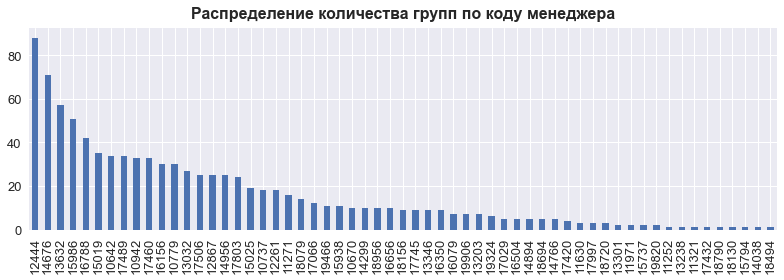

In [23]:
df_features['manager_code'].value_counts().plot(kind='bar', title='Распределение количества групп по коду менеджера')
plt.show()

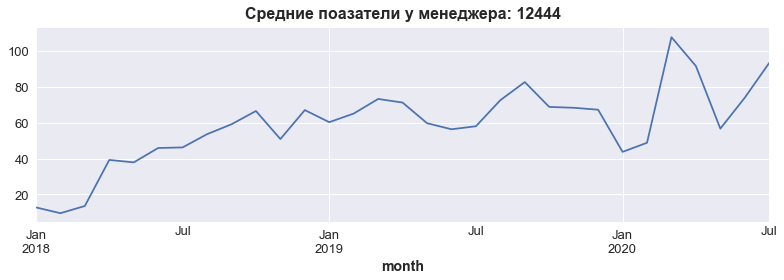

In [24]:
manager_code = 12444

columns = pd.date_range('2018-01-01', '2020-07-01', freq="MS")
agg_manager = df_general.groupby(['manager_code'])[columns].agg('mean').T
agg_manager.loc[:, manager_code].plot(title=f'Средние поазатели у менеджера: {manager_code}')
plt.show()

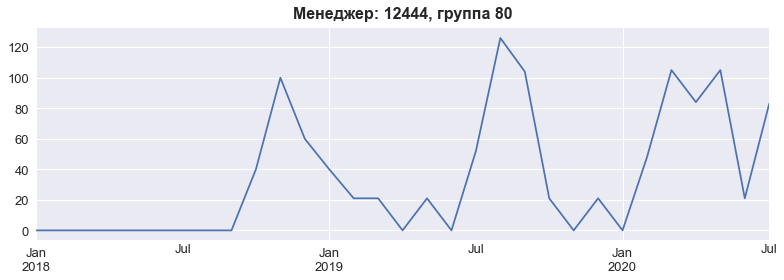

In [25]:
group = 80
manager_groups = df_general[df_general.manager_code == manager_code].loc[:, columns].T
manager_groups.loc[:, group].plot(title=f'Mенеджер: {manager_code}, группа {group}')
plt.show()

### Код материала

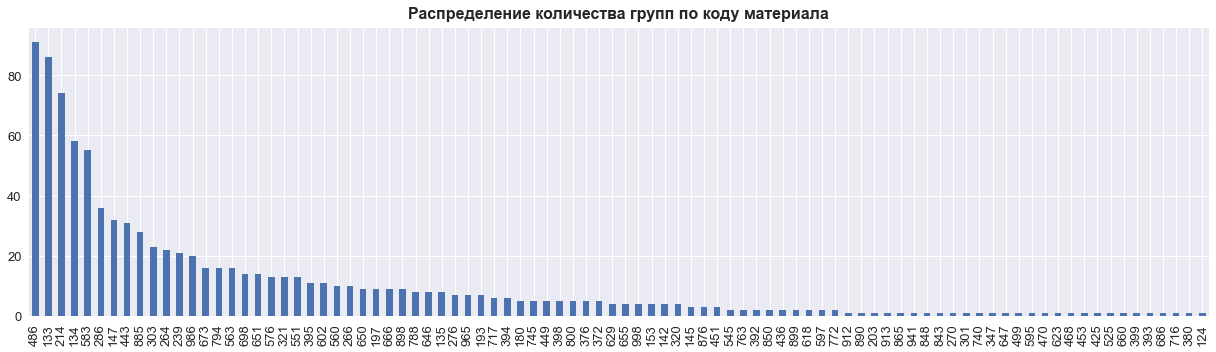

In [26]:
plt.figure(figsize=(17, 5))
df_features['material_code'].value_counts().plot(kind='bar', title='Распределение количества групп по коду материала')
plt.show()

Можно биниризовать: монополисты, менее 10, менее 40 и выше

### Код компании

0 - спот сделки

In [27]:
comp_ = df_features['company_code'].value_counts()
comp_[:20]

0       389
8656     36
2393     21
1378     17
9644     17
1278     16
6385     13
4839     12
5355     10
3408      6
3102      6
3951      6
2834      6
1199      6
9867      5
1257      5
9051      5
4308      5
2401      5
8837      4
Name: company_code, dtype: int64

In [28]:
# компании монополисты
comp_[comp_ == 1].sum()

115

## 3.3 Целевая переменная

### 3.3.1 Распределение

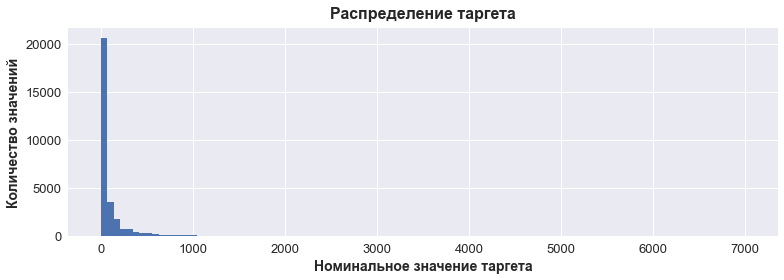

In [29]:
# по всем месяцам
df_target.stack().hist(bins=100)
plt.title('Распределение таргета')
plt.xlabel('Номинальное значение таргета')
plt.ylabel('Количество значений')
plt.show()

Преобразуем целевую переменную к нормальному распределению взятием логарифма от ЦП

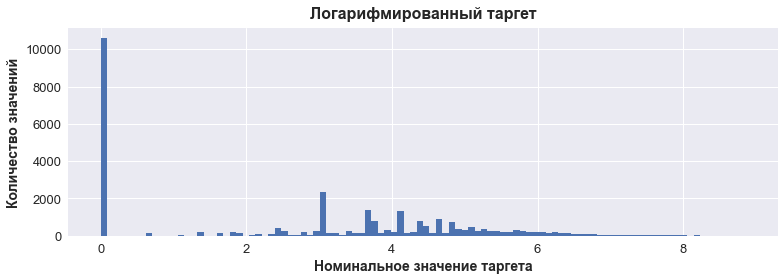

In [30]:
# по всем месяцам
np.log1p(df_target.stack()).hist(bins=100)
plt.title('Логарифмированный таргет')
plt.xlabel('Номинальное значение таргета')
plt.ylabel('Количество значений')
plt.show()

Распределение преобразовалось ближе к нормальному, но в 0 явный преобладающий выброс.

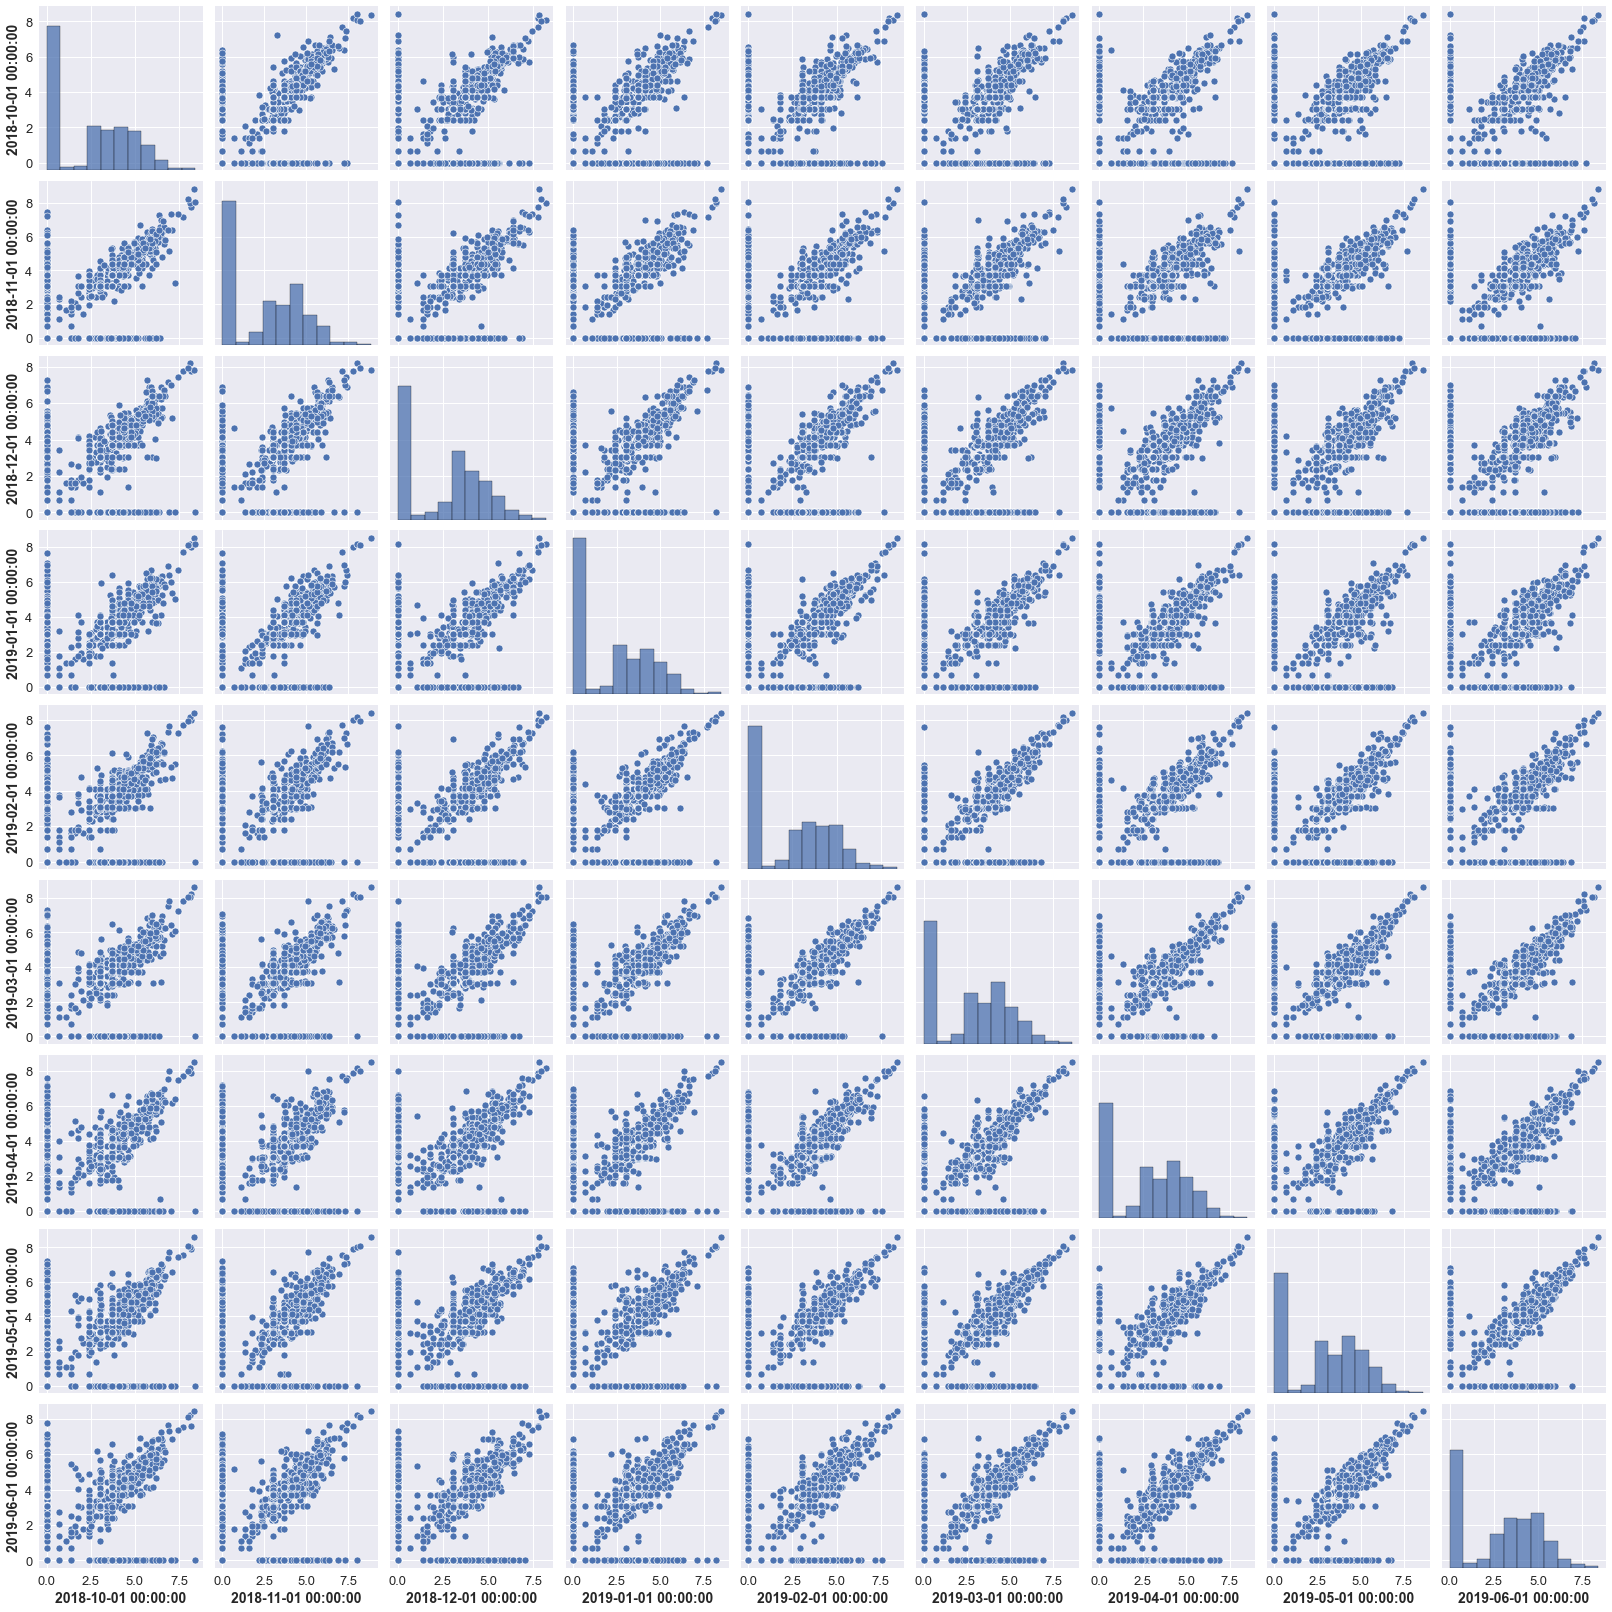

In [31]:
# зависимости таргета относительно таргета других месяцов
df_target_log = np.log1p(df_target)
sns.pairplot(df_target_log.iloc[:,9:18])
plt.show()

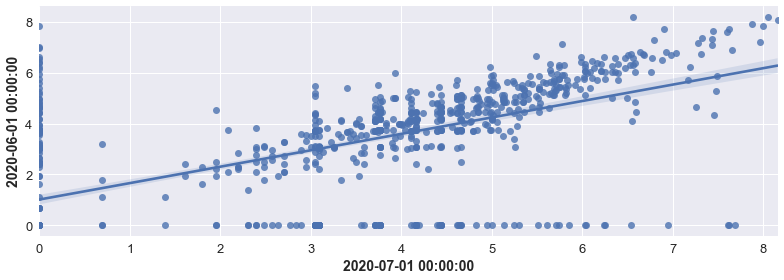

In [32]:
month = pd.Timestamp('2020-07-01')
month2 = pd.Timestamp('2020-06-01')
sns.regplot(x=df_target_log[month], y=df_target_log[month2], data=df_target_log)
plt.show()

По графику видно - нули мешают строить оптимальную линию регрессии

Была идея сделать 2 модели:
   + 1 - бинарная классификация 0 и не 0
   + 2 - регрессия для ненулевых значений
   
Реализовал гипотезу в виде: вероятностный результат модели классификации становиться новым признаком для модели регрессии. Однако результаты итоговых предсказаний ухудшились. Возможно из-за утечек данных, так как тренировал модель во-первых на тех же данных, что и регрессию, во-вторых классификацию обучал на тех же тренировочных данных, для которых потом получал новый признак вероятности. 

### 3.3.2 Автокорреляция

Автокорреляция - корреляция временного ряда относительно своей копии, сдвинутой во времени. Сдиг он же лаг, можно задать в встроенной функции `autocorr`

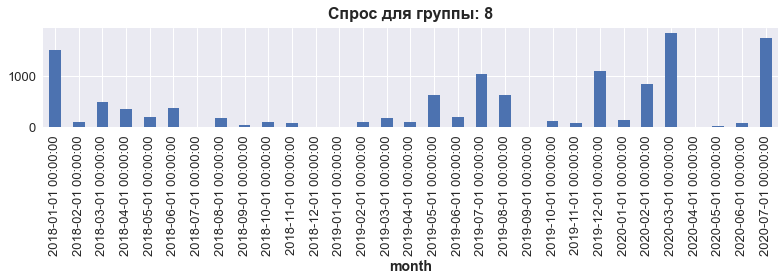

In [33]:
group = 8
s = df_target.iloc[group]
s.plot(kind='bar')
plt.title(f'Спрос для группы: {group}')
plt.show()

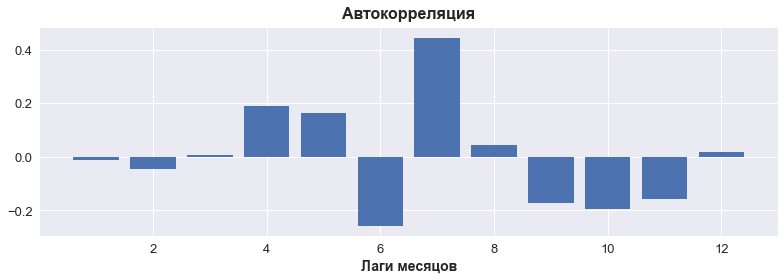

In [34]:
acorrs = [s.autocorr(lag=lag) for lag in range(1, 13)]
plt.bar(range(1, 13), acorrs)
plt.title('Автокорреляция')
plt.xlabel('Лаги месяцов')
plt.show()

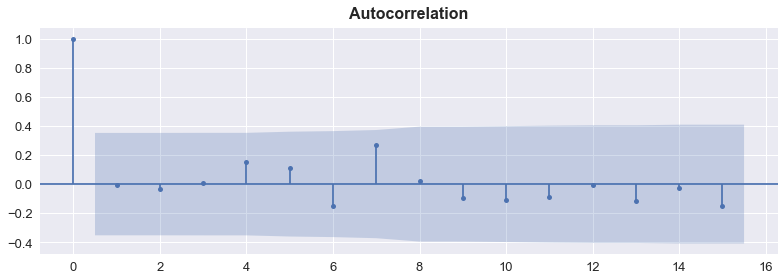

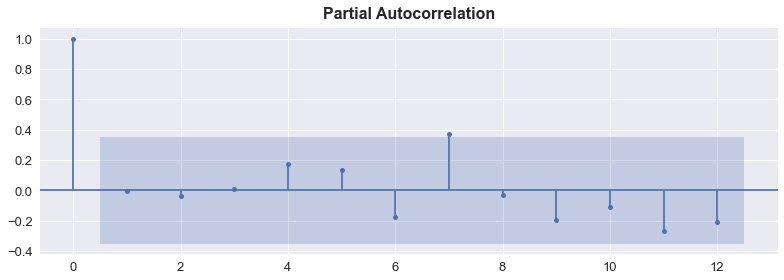

In [35]:
# из пакета statsmodels
plot_acf(s);
plot_pacf(s, lags=12);

Идея для нового признака заключается в поиске максимальной авмтокорреляции ряда. Так как необходимо предсказать таргет для следующего меясца, будем брать значение таргета, следующее за таргетом с максимальной автокорреляцией.

In [36]:
def get_autocorrelation(df):
    """Вычисляет значение тагрета следующего за таргетом с наибольшей автокорреляцией"""
    df = df.copy()
    # Создаем таблицу автокорреляций
    df_acorr = pd.DataFrame([], index=df.index)
    for lag in range(1, len(df.columns)):
        df_acorr[lag] = df.apply(lambda s: s.autocorr(lag=lag), axis=1).fillna(0) 
        
    # выбираем лаг для максимальной автокорреляции. 
    #(минус ставим для удобства поиска следущего значения, используя отрицательную индексацию)
    ind_max = -df_acorr.idxmax(axis=1) 
    
    best_target = []
    for seria, ind in zip(df.iterrows(), ind_max):
        best_target.append(seria[1].iloc[ind])
        
    seria_accor = pd.Series(best_target, name='target_next_max_accor')
    return seria_accor

In [37]:
get_autocorrelation(df_target)

0        0.0
1      249.0
2      100.0
3        0.0
4       40.0
       ...  
936     83.0
937      5.0
938     50.0
939      0.0
940     21.0
Name: target_next_max_accor, Length: 941, dtype: float64

## 3.4 Редкий хаотичный спрос

[Обзор классических методов прогнозирования спроса.](https://fnow.ru/articles/review-of-classical-methods-of-demand-forecasting)

[Прогнозирование редких продаж. Метод Кростона](http://scm.center/Croston)

[Практические аспекты прогнозирования временных рядов: что делать, если более 30% времени спрос на позицию не предъявляется вообще.](https://analytera.ru/about/stati/prakticheskie-aspekty-prognozirovaniya-vremennyh-r/)

[Метод Кростона в модификации Синтетоса, Бойлана в прогнозировании товарных запасов](https://cyberleninka.ru/article/n/metod-krostona-v-modifikatsii-sintetosa-boylona-v-prognozirovanii-tovarnyh-zapasov/viewer)

https://stackoverflow.com/questions/52253563/user-defined-croston-function-in-python

Забегая вперед резюмирую: пробовал применить метод Кростона, выделяя новые признаки для модели такие как экспоненциально сглаженные периоды между сделками и объемы сделок, интенсивность спроса, вероятность спроса, но ничего из этого модель не улучшило. Однако признаки интересные и стоят изучения

In [38]:
def get_croston(seria):
    """ Вычисляются период, таргет и интенсивность по методу Кростона"""
    group = seria.name
    df = seria.reset_index().reset_index()
    df = df[df[group] != 0]
    if len(df): 
        df['interval'] = (df['index'] - df['index'].shift(1)).dropna()
        periods = df['interval']
        values = df[group]
        value_ewm = values.ewm(alpha=0.5).mean().iloc[-1]
        periods_ewm = periods.ewm(alpha=0.5).mean().iloc[-1]
        intensity  = value_ewm / periods_ewm
        return pd.Series([value_ewm, periods_ewm, intensity],
                         index=['value_ewm', 'periods_ewm', 'intensity'])

In [39]:
def get_zeros_statistics(seria):
    """ Вычисляет нулевые месячные статистики. В расчете игнорируются нули до первой сделки"""
    group = seria.name
    s = seria.reset_index(drop=True).reset_index()
    s = s[s[group] != 0]
    if len(s):
        zeros_massive = s['index'] - s['index'].shift(1) - 1
        zeros_massive = zeros_massive.dropna()
        zeros_massive = zeros_massive[zeros_massive!=0]
        zeros_count = zeros_massive.count()
        zeros_mean = zeros_massive.mean()
        zeros_min = zeros_massive.min()
        zeros_max = zeros_massive.max()
        return pd.Series([zeros_count, zeros_mean, zeros_min, zeros_max],
                         index=['zeros_count', 'zeros_mean', 'zeros_min', 'zeros_max'])
    

In [40]:
df_target.apply(get_zeros_statistics, axis=1).fillna(0)

,zeros_count,zeros_mean,zeros_min,zeros_max
0,0.0,0.000000,0.0,0.0
1,1.0,10.000000,10.0,10.0
2,3.0,5.000000,2.0,10.0
3,4.0,3.500000,2.0,6.0
4,7.0,1.285714,1.0,2.0
...,...,...,...,...
936,0.0,0.000000,0.0,0.0
937,4.0,1.250000,1.0,2.0
938,0.0,0.000000,0.0,0.0
939,0.0,0.000000,0.0,0.0


In [41]:
df_target.apply(get_croston, axis=1).fillna(0)

,value_ewm,periods_ewm,intensity
0,106.009972,1.000000,106.009972
1,248.201142,1.000153,248.163275
2,104.199413,3.542074,29.417624
3,22.962081,3.093875,7.421787
4,46.957048,2.143696,21.904710
...,...,...,...
936,84.428571,1.000000,84.428571
937,6.288514,1.132905,5.550789
938,46.705923,1.000000,46.705923
939,87.694582,1.000000,87.694582


# 4 Генерация признаков 

## 4.1 Внутригрупповые признаки

Признаки основанные на временном интервале каждой группы по отдельности

In [101]:
def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Вычисляет внутригрупповые признаки для месяца `month`."""
        
    # определяем начальную и конечную дату аггрегирования данных
    # смещением на 6 и 1 месяцев относительно предсказываемого месяца
    start_period = month - pd.offsets.MonthBegin(6)
    end_period = month - pd.offsets.MonthBegin(1)
    month_12 = month - pd.offsets.MonthBegin(12)
    ##### Годовой интервал #####
    df_year = df.loc[:, month_12:end_period].copy()
    
    # выбираем даты по end_period включительно
    df = df.loc[:, :end_period]
    
    features = pd.DataFrame([], index=df.index)
    # создаем признак месяца
    features["month"] = month.month
    # квартал
    features["quarter"] = month.quarter
    # создаем 6 призаков - 6 последних месяцев
    features[[f"vol_tm{i}" for i in range(6, 0, -1)]] = df.loc[:, start_period:end_period].copy()
    
    # скользящие значения с окном 12 месяцев
    rolling = df.rolling(12, axis=1, min_periods=1)
    # среднее
    features = features.join(rolling.mean().iloc[:, -1].rename("last_year_avg"))
    # минимум
    features = features.join(rolling.min().iloc[:, -1].rename("last_year_min"))
    # максимум
    features = features.join(rolling.max().iloc[:, -1].rename("last_year_max"))
    
    # скользящие значения с окном 6 месяцев
    rolling = df.rolling(6, axis=1, min_periods=1)
    # среднее
    features = features.join(rolling.mean().iloc[:, -1].rename("half_year_avg"))
    # минимум
    features = features.join(rolling.min().iloc[:, -1].rename("half_year_min"))
    # максимум
    features = features.join(rolling.max().iloc[:, -1].rename("half_year_max"))

    
    # экспотенциальное сглаживание
    ewm = df.ewm(alpha=0.5, adjust=False, axis=1)
    ewm_mean = ewm.mean().iloc[:, -1].rename("ewm_0.5")
    features = features.join(ewm_mean)
    
    # отношение разницы лагов от 1 до 6 к первому лагу 
    for lag in range(1, 7):
        diff = df.diff(periods=lag, axis=1)
        features[f'diff_ratio_{lag}'] =  diff.iloc[:, -1] / (features['vol_tm1'] + 1e-3)
    
    # относительные годовые статистики
    features['last_year_max_to_1'] = features['vol_tm1'] / (features["last_year_max"] + 1e-3)
    features['last_year_min_to_1'] = features['vol_tm1'] / (features["last_year_min"] + 1e-3)
    features['last_year_avg_to_1'] = features['vol_tm1'] / (features["last_year_avg"] + 1e-3)
    
    ### Автокорреляция ###
    seria_accor = get_autocorrelation(df)
    features = features.join(seria_accor)
    
#     ### Кростон ###
#     df_croston = df.apply(get_croston, axis=1).fillna(0)
#     features = features.join(df_croston.iloc[:, 1:])
    return features

## 4.2 Внешнегрупповые признаки

Показатели спроса относительно категориальных признаков по всем группам

In [102]:
def get_features2(df_general, month):
    """  Внешнегрупповые признаки:
            1. Вычисляются средние показатели за предыдущий месяц для каждой компоненты группы
            2. Каждая компонента группы разбивается на классы     
    """
    month_ago = month - pd.offsets.MonthBegin(1)
    month_start = month - pd.offsets.MonthBegin(12)
    month_period = pd.date_range(month_start, month_ago, freq='MS')

    df = df_general.copy()
    features = df[AGG_COLS + MATERIALS]
    #среднее в стране за последний месяц
    df_country = df.groupby('country', as_index=False)[[month_ago]]\
                           .mean()\
                           .rename({month_ago:'country_mean_month_ago'}, axis=1)
    features = features.merge(df_country, how='left')
    
    #среднее по региону за последний месяц
    df_region = df.groupby('region', as_index=False)[[month_ago]]\
                           .mean()\
                           .rename({month_ago:'region_mean_month_ago'}, axis=1)
    
    features = features.merge(df_region, how='left')
   
    #среднее по коду компании за последний месяц
    df_company = df.groupby('company_code', as_index=False)[[month_ago]]\
                           .mean()\
                           .rename({month_ago:'company_mean_month_ago'}, axis=1)
    features = features.merge(df_company, how='left')
    
    #среднее по менеджеру за последний месяц
    df_manager = df.groupby('manager_code', as_index=False)[[month_ago]]\
                           .mean()\
                           .rename({month_ago:'manager_mean_month_ago'}, axis=1)  
    features = features.merge(df_manager, how='left')
    
    #среднее по коду товара за последний месяц
    df_material_code = df.groupby('material_code', as_index=False)[[month_ago]]\
                           .mean()\
                           .rename({month_ago:'material_mean_month_ago'}, axis=1) 
    features = features.merge(df_material_code, how='left')
    
    # Сочетание всех компонент группы
    features['mix_ewm'] = 0.2 * features['material_mean_month_ago'] + 0.2 * features['manager_mean_month_ago'] \
                          + 0.2 * features['region_mean_month_ago'] + 0.2 * features['company_mean_month_ago'] \
                          + 0.2 * features['country_mean_month_ago']
    
    ################## КЛАССЫ ###################
    # разбиение менеджеров на классы по количесту групп
    mclass = df['manager_code'].value_counts()\
                               .apply(lambda x: 0 if x == 1 else
                                      (1 if x<10 else 
                                       (2 if x <=40 else 3)))\
                               .rename('class_manager')
    features = features.merge(mclass.to_frame(), right_index=True, left_on='manager_code', how='left')
    
    # разбиение компаний на классы по количесту групп
    company_class = df['company_code'].value_counts()\
                               .apply(lambda x: 0 if x == 1 else
                                      (1 if x<10 else 
                                       (2 if x <=40 else 3)))\
                               .rename('class_company')
    features = features.merge(company_class.to_frame(), right_index=True, left_on='company_code', how='left')
    
    # разбиение продукта на классы по количесту групп
    material_class = df['material_code'].value_counts()\
                               .apply(lambda x: 0 if x == 1 else
                                      (1 if x<10 else 
                                       (2 if x <=40 else 3)))\
                               .rename('class_material')
    features = features.merge(material_class.to_frame(), right_index=True, left_on='material_code', how='left')
    
    # разбиение регионов на классы по количесту групп
    region_class = df['region'].value_counts()\
                               .apply(lambda x: 0 if x == 1 else
                                      (1 if x<10 else 
                                       (2 if x <20 else 
                                        (3 if x <45 else 4))))\
                               .rename('class_region')
    features = features.merge(region_class.to_frame(), right_index=True, left_on='region', how='left')
    
    # Разбиение стран на класссы
    Asia = ['Китай', 'Индия', 'Турция']
    Europe = ['Испания', 'Эстония', 'Дания', 'Словакия', 'Швеция', 'Венгрия', 'Швейцария', 'Литва', 'Соед. Королев.',
         'Бельгия', 'Сербия', 'Нидерланды', 'Италия', 'Австрия', 'Финляндия', 'Франция', 'Чехия', 'Германия',
         'Польша']
    
    country_class = df['country'].apply(lambda x: 0 if x == 'Россия' 
                                            else (1 if x in Asia 
                                                  else (2 if x in Europe else 3)))\
                                 .rename('class_country')
    features['class_country'] = country_class
    return features

## 4.3 Контрактные признаки

### 4.3.1 Частота сделок

In [103]:
def get_features_contract(df, month):
    """ 1. Вычисляем общее количество сделок в прошлом месяце, за полгода и частоту сделок 
        2. Ставим флаги для контрактов каждого типа в прошлом месяце
    """
    month_ago = month - pd.offsets.MonthBegin(1)
    month_6_ago = month - pd.offsets.MonthBegin(6)
    period = pd.date_range(month_6_ago, month_ago, freq='MS')
    
    df = df.copy()
    # количество сделок за прошлый месяц
    df_contract = df.loc[:, (slice(None), [month_ago])]
    features = df_contract.sum(axis=1).to_frame().rename({0:'count_deal_mounth_ago'}, axis=1)
    
    # количество сделок за полгода
    df_contract_6m = df.loc[:, (slice(None), period)]
    features_6m = df_contract_6m.sum(axis=1).rename('count_deal_period_6_mounth')
    
    # частота сделок за полгода
    frequency_deal_half_year = features_6m / len(period)
    
    # отношение частот сделок
    features['ratio_deal_half_to_1'] = features['count_deal_mounth_ago'] /\
                                     (frequency_deal_half_year + 1e-3)
    
    # Флаги для наименования сделки в прошлом месяце
    df_deal = df_contract.where(df_contract == 0, 1).droplevel(1, axis=1)
    features = features.join(df_deal)
    return features.reset_index()

In [104]:
get_features_contract(df_contract, month).head()

,material_code,company_code,country,region,manager_code,count_deal_mounth_ago,ratio_deal_half_to_1,Спот,Контракт,Contract + Spot
0,124,7278,Россия,Респ. Татарстан,17460,0,0.000000,0,0,0
1,133,0,Белоруссия,Минская обл.,10942,14,2.048481,1,0,0
2,133,0,Белоруссия,Могилевская обл.,10942,4,5.991013,1,0,0
3,133,0,Белоруссия,г. Минск,10942,1,1.996008,1,0,0
4,133,0,Казахстан,г. Нур-Султан,13301,0,0.000000,0,0,0


### 4.3.2 Последняя сделка

In [105]:
def get_days_last_contact(df, month):
    """ Вычисляем какое количество дней назад была совершена последняя сделка, относительно месяца 'month',
        ограничиваясь интервалом в 12 месяцев, и в конце берем обратную величину от найденного количества.
    """
    df = df.copy()
    # таблица с количеством дней от последней сделки, но не более чем 12 месяцев
    df_days = pd.DataFrame(np.zeros_like(df.index), index=df.index, columns=['last_deal_in_days'])
    for lag in range(1, 13):
        # прошлый месяц
        last_month = month - pd.offsets.MonthBegin(lag)
        # всего дней в месяце
        all_days = last_month.days_in_month
        # день последней сделки, 0 - если не было сделок
        df_lag = df[last_month].apply(lambda row: row[row>0].index.max().day, axis=1).fillna(0)
        # разница в днях от предсказываемого месяца до последней сделки
        df_diff = (all_days - df_lag).rename(f'lag_{lag}')
        # присоединяем к заготовке
        df_days = df_days.join(df_diff)
        # отбираем только те группы в которых сделок в текущем месяце не было 
        df = df.loc[df_diff[df_diff==all_days].index]
    df_days['last_deal_in_days'] = df_days.sum(axis=1) 
    # берем обратную величину
    df_days['ratio_last_deal'] = 1 / (df_days['last_deal_in_days'] + 1)
    return df_days.loc[:,'ratio_last_deal'].reset_index()

In [106]:
get_days_last_contact(df_date, month).head()

,material_code,company_code,country,region,manager_code,ratio_last_deal
0,124,7278,Россия,Респ. Татарстан,17460,0.003185
1,133,0,Белоруссия,Минская обл.,10942,1.000000
2,133,0,Белоруссия,Могилевская обл.,10942,0.111111
3,133,0,Белоруссия,г. Минск,10942,0.033333
4,133,0,Казахстан,г. Нур-Султан,13301,0.027027


## 4.4 Создание всех признаков

Создадим все признаки для одного предсказываемого месяца

In [107]:
def get_all_features(data, month):
    """ Прототип функции для файла 'predict' """
    # вспомогательные таблицы
    df_general = data.groupby(AGG_COLS + MATERIALS + ["month"])['volume'].sum().unstack(fill_value=0).reset_index()
    df_target = df_general.select_dtypes('float')
    df_contract = data.groupby(AGG_COLS+['contract_type']+['month']).size()\
                  .unstack(['contract_type']+['month'], fill_value=0)\
    
    df_features = df_general[AGG_COLS + MATERIALS]
    df_date = data.groupby(AGG_COLS+['month']+['date'])['volume'].sum().unstack(['month', 'date'], fill_value=0)
    
    # логарифмируем таргет
    df_target_log = np.log1p(df_target)
    
    # создание признаков
    df_f1 = get_features(df_target_log, month)
    month_features = df_features.join(df_f1)
    
    df_f2 = get_features2(df_general, month)
    month_features = month_features.merge(df_f2, how='left')

    df_f3 = get_features_contract(df_contract, month)
    month_features = month_features.merge(df_f3, how='left')
    
    df_f4 = get_days_last_contact(df_date, month)
    month_features = month_features.merge(df_f4, how='left')
    return month_features

In [108]:
month = pd.Timestamp('2020-07-01')
df_target_log = np.log1p(df_target)
df = data[data.month < month]
get_all_features(df, month).head()

,material_code,company_code,country,region,manager_code,material_lvl1_name,material_lvl2_name,month,quarter,vol_tm6,...,class_company,class_material,class_region,class_country,count_deal_mounth_ago,ratio_deal_half_to_1,Спот,Контракт,Contract + Spot,ratio_last_deal
0,124,7278,Россия,Респ. Татарстан,17460,Базовые полимеры,ПЭ,7,3,0.000000,...,0,0,3,0,0,0.000000,0,0,0,0.002725
1,133,0,Белоруссия,Минская обл.,10942,Базовые полимеры,ПЭ,7,3,2.890372,...,3,3,1,3,9,1.173760,1,0,0,1.000000
2,133,0,Белоруссия,Могилевская обл.,10942,Базовые полимеры,ПЭ,7,3,0.000000,...,3,3,1,3,0,0.000000,0,0,0,0.019231
3,133,0,Белоруссия,г. Минск,10942,Базовые полимеры,ПЭ,7,3,0.000000,...,3,3,1,3,0,0.000000,0,0,0,0.010989
4,133,0,Казахстан,г. Нур-Султан,13301,Базовые полимеры,ПЭ,7,3,0.000000,...,3,3,0,3,1,1.996008,1,0,0,1.000000


Создание фичей для тренировочных данных всех месяцов

In [109]:
def get_all_features_train(month):
    """ Вычисляет признаки для месяца для тренировочных данных"""
    df_f1 = get_features(df_target_log, month)
    month_features = df_features.join(df_f1)

    df_f2 = get_features2(df_general, month)
    month_features = month_features.merge(df_f2, how='left')

    df_f3 = get_features_contract(df_contract, month)
    month_features = month_features.merge(df_f3, how='left')
    
    df_f4 = get_days_last_contact(df_date, month)
    month_features = month_features.merge(df_f4, how='left')
    return month_features

In [110]:
month = pd.Timestamp('2020-05-01')
get_all_features_train(month).tail()

,material_code,company_code,country,region,manager_code,material_lvl1_name,material_lvl2_name,month,quarter,vol_tm6,...,class_company,class_material,class_region,class_country,count_deal_mounth_ago,ratio_deal_half_to_1,Спот,Контракт,Contract + Spot,ratio_last_deal
936,986,9943,Россия,Смоленская обл.,17460,Базовые полимеры,ПЭ,5,2,0.000000,...,0,2,3,0,5,3.331113,0,1,0,0.250000
937,998,0,Россия,Ленинградская обл.,18079,Базовые полимеры,ПП,5,2,0.000000,...,3,1,3,0,0,0.000000,0,0,0,0.019608
938,998,3380,Россия,Ленинградская обл.,14956,Базовые полимеры,ПП,5,2,4.634729,...,1,1,3,0,7,1.076757,0,1,0,1.000000
939,998,5410,Россия,г. Санкт-Петербург,14956,Базовые полимеры,ПП,5,2,4.948760,...,1,1,3,0,5,0.789349,0,1,0,0.100000
940,998,6346,Россия,Респ. Башкортостан,10737,Базовые полимеры,ПП,5,2,3.713572,...,1,1,2,0,2,1.498876,0,1,0,0.125000


In [111]:
# тренеровочный период
tr_range = pd.date_range("2019-01-01", "2019-06-01", freq="MS")
# валидационный период
val_range = pd.date_range("2019-07-01", "2019-12-01", freq="MS")
# тестовый период
ts_range = pd.date_range("2020-01-01", "2020-07-01", freq="MS")

In [112]:
full_features = {}

for dataset, dataset_range in tqdm(zip(["tr", "val", "ts"], [tr_range, val_range, ts_range])):
    dataset_features = []
    for target_month in tqdm(dataset_range):
        # для каждого месяца генерим фичи
        features = get_all_features_train(target_month)
        features["target"] = df_target_log[target_month]
        dataset_features.append(features)
    # для каждого периода имеем датасет из фич каждого месяца    
    full_features[dataset] = pd.concat(dataset_features, ignore_index=True)

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

# 5 Трансформация и анализ признаков

Удаление признаков

In [113]:
# Удалим компоненты групп, так как информация о них останется в выделенных ранее классах
drop_cols = ['company_code',  
             'region',
             'country',
             'material_code',
             'manager_code'
            ]

for name, dataset in full_features.items():
    dataset = dataset.drop(drop_cols, axis=1, inplace=True)

Инвентаризация признаков

In [114]:
# Интересный факт: порядок колонок влияет на итоговый результат модели.
CAT_COLS = ['Contract + Spot',
            'class_company',
            'class_country',
            'quarter',
            'class_manager',
            'class_material',
            'material_lvl2_name',
            'month',
            'Контракт',
            'material_lvl1_name',
            'Спот',
            'class_region'
           ]

FTS_COLS = full_features['tr'].columns[:-1]
TARGET = "target"
NUM_COLS = FTS_COLS.difference(CAT_COLS, sort=False)
NUM_COLS

Index(['vol_tm6', 'vol_tm5', 'vol_tm4', 'vol_tm3', 'vol_tm2', 'vol_tm1',
       'last_year_avg', 'last_year_min', 'last_year_max', 'half_year_avg',
       'half_year_min', 'half_year_max', 'ewm_0.5', 'diff_ratio_1',
       'diff_ratio_2', 'diff_ratio_3', 'diff_ratio_4', 'diff_ratio_5',
       'diff_ratio_6', 'last_year_max_to_1', 'last_year_min_to_1',
       'last_year_avg_to_1', 'target_next_max_accor', 'country_mean_month_ago',
       'region_mean_month_ago', 'company_mean_month_ago',
       'manager_mean_month_ago', 'material_mean_month_ago', 'mix_ewm',
       'count_deal_mounth_ago', 'ratio_deal_half_to_1', 'ratio_last_deal'],
      dtype='object')

## 5.1 One hot encoding

Закодируем категориальные признаки

In [115]:
def get_features_ohe(df):
    """ Кодирует тренировочные данные в OHE """
    df = df.copy()
    encoder = OneHotEncoder(drop='if_binary', dtype='int')
    X_ohe = encoder.fit_transform(df[CAT_COLS]).toarray()
    df_cat = pd.DataFrame(X_ohe, columns=encoder.get_feature_names(CAT_COLS), index=df.index)
    df_res = df.drop(CAT_COLS, axis=1).join(df_cat)
    
    with open('encoder.ohe', 'wb') as f:
        pickle.dump(encoder, f)
        
    return df_res

In [116]:
def transorm_to_ohe(df):
    """ Трансформирует тестовые данные в OHE """
    
    with open('encoder.ohe', 'rb') as f:
        encoder = pickle.load(f)
        
    df = df.copy()
    X_ohe = encoder.transform(df[CAT_COLS]).toarray()
    df_cat = pd.DataFrame(X_ohe, columns=encoder.get_feature_names(CAT_COLS), index=df.index)
    df_res = df.drop(CAT_COLS, axis=1).join(df_cat)
    return df_res

In [117]:
X_train_raw = full_features["tr"][FTS_COLS]
X_val_raw = full_features["val"][FTS_COLS]
X_test_raw = full_features["ts"][FTS_COLS]

y_train = full_features["tr"][TARGET]
y_val = full_features["val"][TARGET]
y_test = full_features["ts"][TARGET]

get_features_ohe(pd.concat([X_train_raw, X_val_raw, X_test_raw], ignore_index=True))
X_full = transorm_to_ohe(pd.concat([X_train_raw, X_val_raw, X_test_raw], ignore_index=True))
y_full = pd.concat([y_train, y_val, y_test], ignore_index=True) 

In [118]:
X_train = X_full.iloc[:len(X_train_raw)]
X_val = X_full.iloc[len(X_train_raw):len(X_train_raw) + len(X_val_raw)]
X_test = X_full.iloc[len(X_train_raw) + len(X_val_raw):]

In [119]:
# закодированные категориальные признаки
cat_columns = [col for col in X_full.columns if col not in NUM_COLS]
cat_columns

['Contract + Spot_1',
 'class_company_0',
 'class_company_1',
 'class_company_2',
 'class_company_3',
 'class_country_0',
 'class_country_1',
 'class_country_2',
 'class_country_3',
 'quarter_1',
 'quarter_2',
 'quarter_3',
 'quarter_4',
 'class_manager_0',
 'class_manager_1',
 'class_manager_2',
 'class_manager_3',
 'class_material_0',
 'class_material_1',
 'class_material_2',
 'class_material_3',
 'material_lvl2_name_Гликоли',
 'material_lvl2_name_ПП',
 'material_lvl2_name_ПСВ',
 'material_lvl2_name_ПЭ',
 'material_lvl2_name_ТЭП',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'Контракт_1',
 'material_lvl1_name_Базовые полимеры',
 'material_lvl1_name_Пластики и продукты органического синтеза',
 'material_lvl1_name_Синтетические каучуки',
 'Спот_1',
 'class_region_0',
 'class_region_1',
 'class_region_2',
 'class_region_3',
 'class_region_4']

## 5.2 Матрица корреляций

<AxesSubplot:>

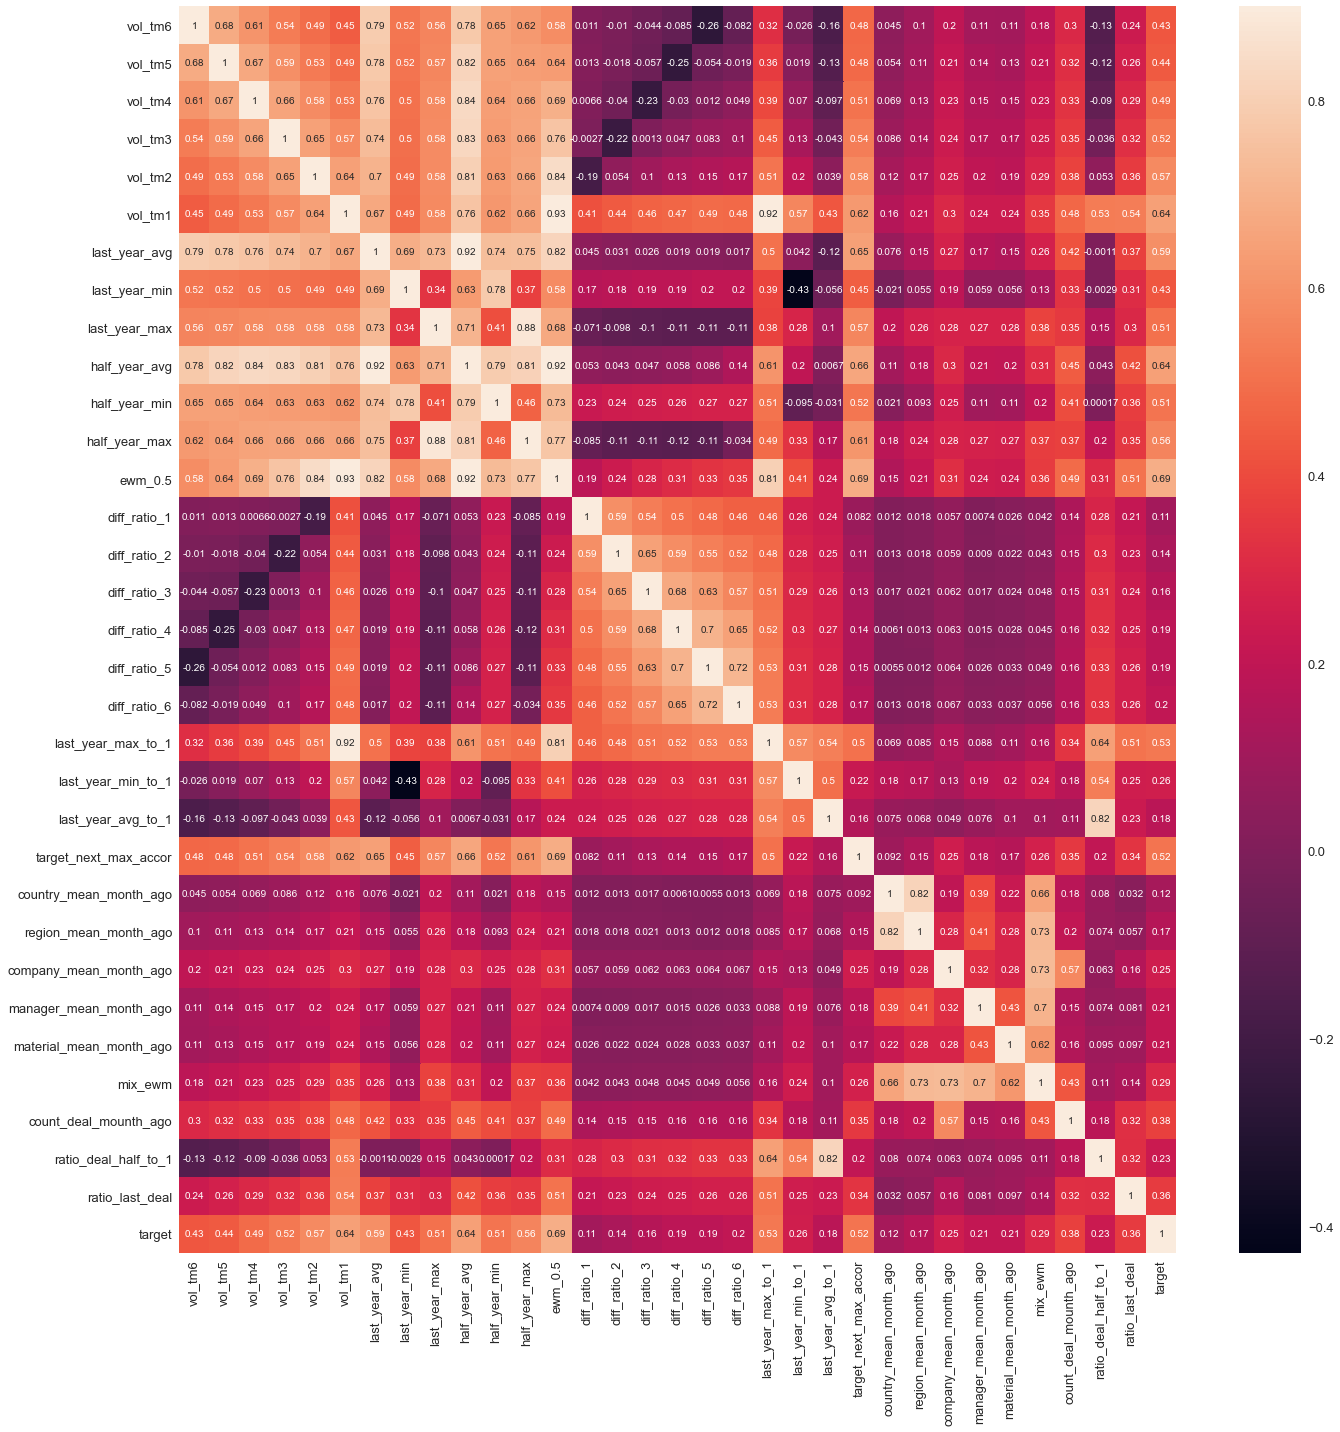

In [121]:
Xy = pd.concat([X_full[NUM_COLS], y_full], axis=1)

plt.figure(figsize=(20, 20))
sns.heatmap(Xy.corr(),
            annot=True, vmax=.9, annot_kws={'fontsize':10})

# 6 Моделирование

In [122]:
def print_error(model, X_train, y_train, X_val=None, y_val=None, X_test=None, y_test=None):
    tr_preds = model.predict(X_train).clip(.0)
    tr_norm_pred = np.expm1(tr_preds)
    tr_norm_real = np.expm1(y_train)
    
    if X_val is not None:  
        val_preds = model.predict(X_val).clip(.0)
        val_norm_pred = np.expm1(val_preds)
        val_norm_real = np.expm1(y_val)
        
    if X_test is not None:    
        ts_preds = model.predict(X_test).clip(.0)
        ts_norm_pred = np.expm1(ts_preds)
        ts_norm_real = np.expm1(y_test)
    
    print(' '*34, 'origin', ' '*5, 'log')
    print("Ошибка на тренировочном множестве:",
          f'{np.sqrt(mean_squared_log_error(tr_norm_real, tr_norm_pred)):.4f}', 
          f'{np.sqrt(mean_squared_log_error(y_train, tr_preds)):>10.4f}')
    if X_val is not None: 
        print("Ошибка на валидационном множестве:",
              f'{np.sqrt(mean_squared_log_error(val_norm_real, val_norm_pred)):.4f}',
              f'{np.sqrt(mean_squared_log_error(y_val, val_preds)):>10.4f}')
    if X_test is not None:
        print("Ошибка на тестовом множестве:",
              f'{np.sqrt(mean_squared_log_error(ts_norm_real, ts_norm_pred)):>11.4f}',
              f'{np.sqrt(mean_squared_log_error(y_test, ts_preds)):>10.4f}')

## 6.1 Сравнение моделей

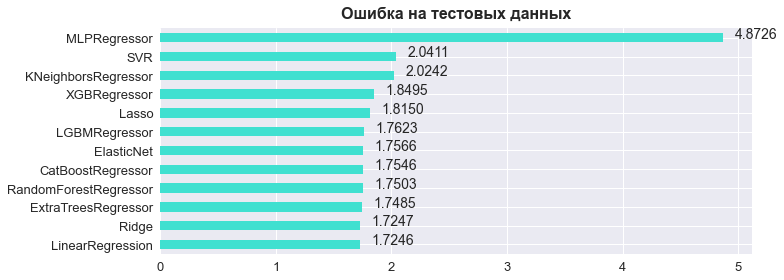

In [123]:
names_models = ['ExtraTreesRegressor', 'RandomForestRegressor', 'KNeighborsRegressor',
                'MLPRegressor', 'LGBMRegressor', 'XGBRegressor', 'CatBoostRegressor',
               'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR']

list_models = [ExtraTreesRegressor(), 
               RandomForestRegressor(), 
               KNeighborsRegressor(),
               MLPRegressor(), 
               LGBMRegressor(), 
               XGBRegressor(),
               CatBoostRegressor(verbose=False, cat_features=cat_columns),
               LinearRegression(), 
               Ridge(), 
               Lasso(), 
               ElasticNet(), 
               SVR()
              ]

df_errors = pd.DataFrame() 
ts_norm_real = np.expm1(y_test)

for mod, name in zip(list_models, names_models):
    mod.fit(X_train, y_train)
    ts_norm_pred = np.expm1(mod.predict(X_test).clip(.0))
    error = np.sqrt(mean_squared_log_error(ts_norm_real, ts_norm_pred))
    df_errors = df_errors.append(pd.DataFrame({'test': [error]}, index=[name]))
    
# отрисовка    
df_errors['test'].sort_values().plot(kind='barh', color='turquoise')
plt.title('Ошибка на тестовых данных')
for  i, error in enumerate(df_errors['test'].sort_values()):
    plt.text(error+0.1, i, f'{error:.4f}', size=14)
plt.tight_layout()    
plt.show()     

Далее будем строить модели *LGBMRegressor*, *Ridge*, *CatBoostRegressor*, *RandomForestRegressor* 

## 6.2 CatBoostRegressor

### 6.2.1 Обучение

[Док. catboost](https://catboost.ai/en/docs/concepts/python-usages-examples)

[introduction to CatBoost regression](https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329)

In [124]:
# class CustomRMSLE(object):
#     def calc_ders_range(self, approxes, targets, weights):
#         assert len(approxes) == len(targets)
#         if weights is not None:
#             assert len(weights) == len(approxes)

#         result = []
#         for index in range(len(targets)):
#             der1 = np.log(targets[index] + 1) - np.log(approxes[index] + 1)
#             der2 = -1 / (approxes[index] + 1)

#             if weights is not None:
#                 der1 *= weights[index]
#                 der2 *= weights[index]

#             result.append((der1, der2))
#         return result

In [125]:
# class RMSLEMetric(object):
#     def get_final_error(self, error, weight):
#         return np.sqrt(error / (weight + 1e-38))

#     def is_max_optimal(self):
#         return False

#     def evaluate(self, approxes, target, weight):
#         assert len(approxes) == 1
#         assert len(target) == len(approxes[0])

#         approx = approxes[0]

#         error_sum = 0.0
#         weight_sum = 0.0

#         for i in range(len(approx)):
#             w = 1.0 if weight is None else weight[i]
#             weight_sum += w
#             error_sum += w * ((np.log(target[i] + 1) - np.log(approx[i] + 1))**2)

#         return error_sum, weight_sum

Применять функцию потерь можно RMSE, так как тагрет заранее прологарифмировали

In [126]:
model = CatBoostRegressor(iterations=1500,
                          early_stopping_rounds=30,
                          depth=6, 
                          cat_features=cat_columns,
                          random_state=RS,
                          verbose=30,

                          )
model.fit(X_train, y_train, eval_set=(X_val, y_val))

Learning rate set to 0.049643
0:	learn: 2.1780018	test: 2.1542751	best: 2.1542751 (0)	total: 25.8ms	remaining: 38.7s
30:	learn: 1.5354407	test: 1.5812568	best: 1.5812568 (30)	total: 416ms	remaining: 19.7s
60:	learn: 1.4500307	test: 1.5410565	best: 1.5410250 (59)	total: 809ms	remaining: 19.1s
90:	learn: 1.4166024	test: 1.5397100	best: 1.5392058 (77)	total: 1.22s	remaining: 18.9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 1.539205809
bestIteration = 77

Shrink model to first 78 iterations.


In [127]:
print_error(model, X_train, y_train, X_val, y_val, X_test, y_test)

                                   origin       log
Ошибка на тренировочном множестве: 1.4303     0.5871
Ошибка на валидационном множестве: 1.5392     0.6016
Ошибка на тестовом множестве:      1.7233     0.6754


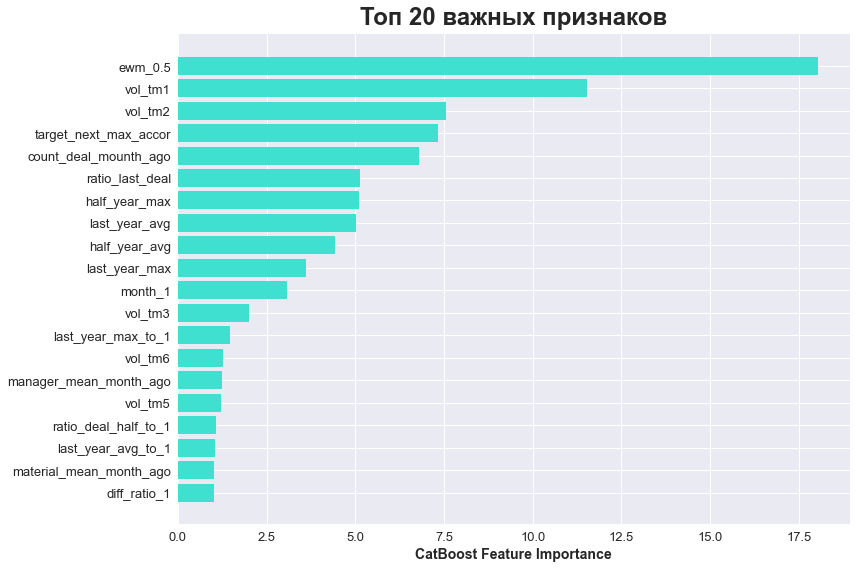

In [128]:
s = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()[-20:]

plt.figure(figsize=(12, 8))
plt.barh(s.index, s, color='turquoise')
plt.title('Топ 20 важных признаков', size=24)
plt.xlabel("CatBoost Feature Importance")
plt.show()

### 6.2.2 Feature selection

[scikit-learn: Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html)

[kaggle: Feature Selection with Permutation Importance](https://www.kaggle.com/paultimothymooney/feature-selection-with-permutation-importance)

[eli5 example, PermutationImportance](https://towardsdatascience.com/next-level-feature-selection-method-with-code-examples-2ba4edb40cd3)

[The 5 Feature Selection Algorithms](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2)


Обучим модель на всех данных и оценим важность признаков с помощью алгоритма *Permutation Importance*

In [72]:
model_full = CatBoostRegressor(iterations=1500,
                          early_stopping_rounds=30,
                          depth=6, 
                          cat_features=cat_columns,
                          random_state=RS,
                          verbose=200,

                          )
model_full.fit(X_full, y_full)

Learning rate set to 0.047917
0:	learn: 2.1882386	total: 34.9ms	remaining: 52.3s
200:	learn: 1.5041279	total: 3.75s	remaining: 24.2s
400:	learn: 1.4260401	total: 7.2s	remaining: 19.7s
600:	learn: 1.3622708	total: 10.8s	remaining: 16.2s
800:	learn: 1.3068087	total: 14.4s	remaining: 12.6s
1000:	learn: 1.2568874	total: 18s	remaining: 9s
1200:	learn: 1.2128284	total: 21.7s	remaining: 5.39s
1400:	learn: 1.1724956	total: 25.3s	remaining: 1.79s
1499:	learn: 1.1514623	total: 27.2s	remaining: 0us


In [73]:
print_error(model_full, X_train, y_train, X_val, y_val, X_test, y_test)

                                   origin       log
Ошибка на тренировочном множестве: 1.1259     0.4925
Ошибка на валидационном множестве: 1.1372     0.4861
Ошибка на тестовом множестве:      1.1846     0.5196


[Как интерпретировать предсказания моделей в SHAP](https://habr.com/ru/post/428213/)

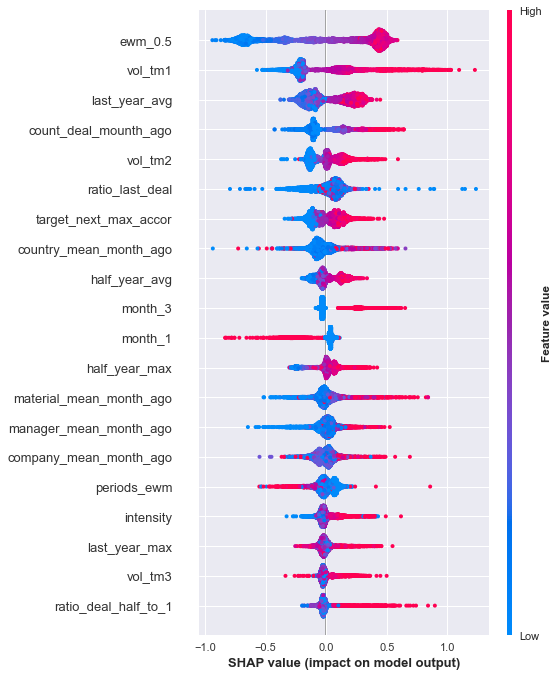

In [74]:
explainer = shap.TreeExplainer(model_full)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)

In [75]:
# with pd.option_context('display.max_rows', 200):
#     s = pd.Series(model_full.feature_importances_, index=X_full.columns).sort_values(ascending=False)
#     display(s)

Permutation importance

[scikit-learn: Пример с графиком Permutation Importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)

In [76]:
result = permutation_importance(model_full, X_full, y_full, n_repeats=10, random_state=0)

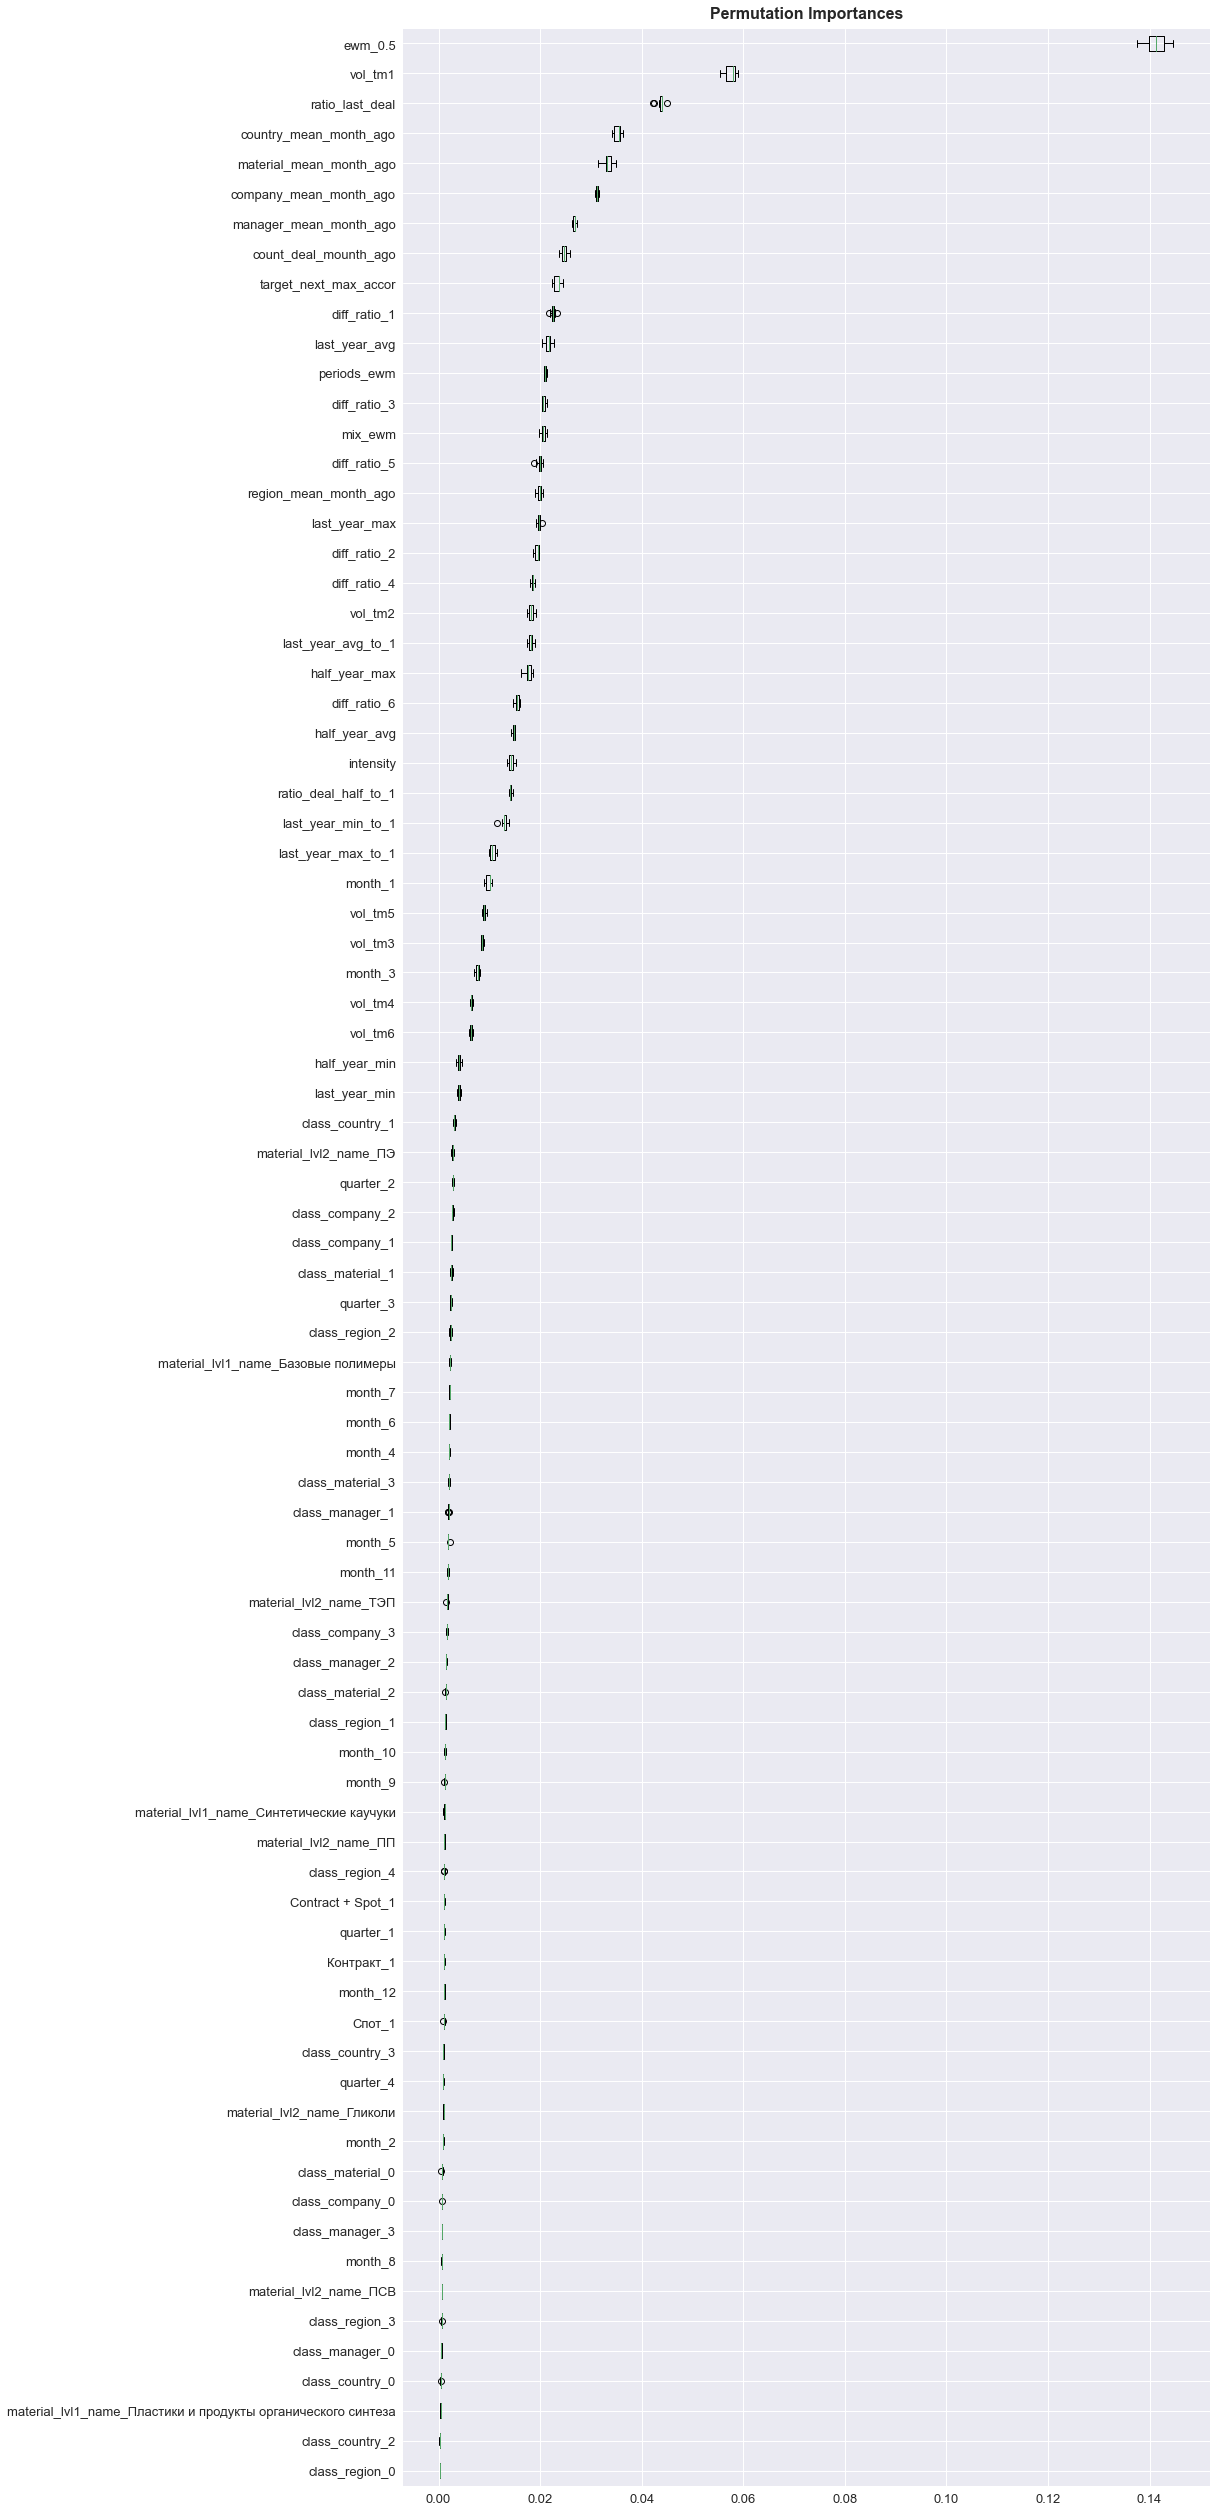

In [77]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(17, 35))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_full.columns[sorted_idx]
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [78]:
s = pd.Series(result.importances_mean, X_full.columns).sort_values(ascending=False)
selected_features = s[s > 0.005].index
selected_features

Index(['ewm_0.5', 'vol_tm1', 'ratio_last_deal', 'country_mean_month_ago',
       'material_mean_month_ago', 'company_mean_month_ago',
       'manager_mean_month_ago', 'count_deal_mounth_ago',
       'target_next_max_accor', 'diff_ratio_1', 'last_year_avg', 'periods_ewm',
       'diff_ratio_3', 'mix_ewm', 'diff_ratio_5', 'region_mean_month_ago',
       'last_year_max', 'diff_ratio_2', 'diff_ratio_4', 'vol_tm2',
       'last_year_avg_to_1', 'half_year_max', 'diff_ratio_6', 'half_year_avg',
       'intensity', 'ratio_deal_half_to_1', 'last_year_min_to_1',
       'last_year_max_to_1', 'month_1', 'vol_tm5', 'vol_tm3', 'month_3',
       'vol_tm4', 'vol_tm6'],
      dtype='object')

In [79]:
new_cat_columns = list(set(cat_columns).intersection(set(selected_features)))
new_cat_columns

['month_1', 'month_3']

In [80]:
model_full_selected = CatBoostRegressor(iterations=1500,
                          early_stopping_rounds=30,
                          depth=6, 
                          cat_features=new_cat_columns,
                          random_state=RS,
                          verbose=200,

                          )
model_full_selected.fit(X_full[selected_features], y_full)

Learning rate set to 0.047917
0:	learn: 2.1878716	total: 28ms	remaining: 42s
200:	learn: 1.5112739	total: 3.32s	remaining: 21.5s
400:	learn: 1.4327547	total: 6.53s	remaining: 17.9s
600:	learn: 1.3690808	total: 9.94s	remaining: 14.9s
800:	learn: 1.3136899	total: 13.3s	remaining: 11.6s
1000:	learn: 1.2647062	total: 16.7s	remaining: 8.31s
1200:	learn: 1.2214643	total: 21s	remaining: 5.22s
1400:	learn: 1.1819880	total: 24.4s	remaining: 1.73s
1499:	learn: 1.1649107	total: 26.1s	remaining: 0us


In [81]:
print_error(model_full_selected, X_train[selected_features], y_train, 
            X_val[selected_features], y_val,
            X_test[selected_features], y_test)

                                   origin       log
Ошибка на тренировочном множестве: 1.1323     0.4952
Ошибка на валидационном множестве: 1.1626     0.4931
Ошибка на тестовом множестве:      1.1939     0.5224


### 6.2.3 Подбор гиперпараметров

In [82]:
model = CatBoostRegressor(
                          early_stopping_rounds=30,
                          cat_features=cat_columns,
                          random_state=RS,
                          verbose=100,
                          )

grid = {'learning_rate': [0.03, 0.12, 0.4, 0.08],
        'depth': [6, 10, 12],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations': [200, 500, 1000, 1500, 2000]}

grid_search_result = model.randomized_search(grid, 
                                             X=X_full, 
                                             y=y_full, 
                                             verbose=False,
                                             )

0:	learn: 3.5589865	test: 3.5182739	best: 3.5182739 (0)	total: 31.9ms	remaining: 6.34s
100:	learn: 1.5872306	test: 1.6020111	best: 1.6020111 (100)	total: 1.86s	remaining: 1.83s
199:	learn: 1.5435735	test: 1.5770272	best: 1.5770272 (199)	total: 3.56s	remaining: 0us

bestTest = 1.577027166
bestIteration = 199

0:	learn: 3.4200931	test: 3.3810682	best: 3.3810682 (0)	total: 22.6ms	remaining: 11.3s
100:	learn: 1.5223541	test: 1.5700986	best: 1.5698817 (97)	total: 1.75s	remaining: 6.91s
200:	learn: 1.4573071	test: 1.5658136	best: 1.5652469 (182)	total: 3.41s	remaining: 5.07s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 1.565246932
bestIteration = 182

0:	learn: 3.3105591	test: 3.2729290	best: 3.2729290 (0)	total: 30.3ms	remaining: 30.2s
100:	learn: 1.4870667	test: 1.5686058	best: 1.5683007 (88)	total: 1.76s	remaining: 15.7s
200:	learn: 1.4025969	test: 1.5636553	best: 1.5636553 (200)	total: 3.42s	remaining: 13.6s
Stopped by overfitting detector  (30 iterations wait)

best

In [83]:
grid_search_result['params']

{'depth': 10, 'l2_leaf_reg': 9, 'iterations': 500, 'learning_rate': 0.08}

In [84]:
model_cat = CatBoostRegressor(
                          early_stopping_rounds=30,
                          cat_features=cat_columns,
                          random_state=RS,
                          verbose=False,
                          depth = 10,
                          l2_leaf_reg = 9,
                          iterations=500,
                          learning_rate=0.08,
                          )
model_cat.fit(X_train, y_train, eval_set=(X_val, y_val))
print_error(model_cat, X_train, y_train, X_val, y_val, X_test, y_test)

                                   origin       log
Ошибка на тренировочном множестве: 1.3210     0.5539
Ошибка на валидационном множестве: 1.5417     0.6002
Ошибка на тестовом множестве:      1.7235     0.6762


## 6.3 LGBMRegressor

In [85]:
model_lgbm = LGBMRegressor(random_state=RS)

grid_lgmb ={ 
        'n_estimators': [200, 400, 700, 1000, 1500],
        'learning_rate': [0.12, 0.03, 0.5, 0.005],
        'colsample_bytree': [0.7, 0.8],
        'max_depth': [4, 6, 10, 12],
        'num_leaves': [10, 20, 30],
        'reg_alpha': [0.5, 0.1, 1.5],
        'reg_lambda': [0.5, 1.0, 1.5],
        'min_split_gain': [0.3, 0.4],
        'subsample': [0.8, 0.9],
        'subsample_freq': [10, 20]
    }

clf = RandomizedSearchCV(model_lgbm, grid_lgmb, random_state=0)
search = clf.fit(X_full, y_full)
search.best_params_

{'subsample_freq': 20,
 'subsample': 0.9,
 'reg_lambda': 1.0,
 'reg_alpha': 1.5,
 'num_leaves': 10,
 'n_estimators': 1000,
 'min_split_gain': 0.4,
 'max_depth': 6,
 'learning_rate': 0.005,
 'colsample_bytree': 0.7}

In [86]:
model_lgbm = LGBMRegressor(random_state=RS, 
                           subsample_freq=20,
                           subsample=0.9,
                           reg_lambda=1.0,
                           reg_alpha=1.5,
                           num_leaves=10,
                           n_estimators=1000,
                           min_split_gain=0.4,
                           max_depth=6,
                           learning_rate=0.005,
                           colsample_bytree=0.7)

model_lgbm.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
print_error(model_lgbm, X_train, y_train, X_val, y_val, X_test, y_test)

                                   origin       log
Ошибка на тренировочном множестве: 1.3813     0.5698
Ошибка на валидационном множестве: 1.5383     0.6004
Ошибка на тестовом множестве:      1.7207     0.6713


## 6.4 RandomForestRegressor

In [87]:
model_rf = RandomForestRegressor(random_state=RS)

grid_rf = { 
        'max_depth':[3, 5, 10, 13], 
        'n_estimators':[100, 200, 400, 600, 900, 1200],
        'max_features':[2, 4, 6, 8, 10],
        'min_samples_leaf': [2, 6, 10, 20],
        'min_samples_split': [4, 8, 12, 16],
}

clf = RandomizedSearchCV(model_rf, grid_rf, random_state=0)
search = clf.fit(X_full, y_full)
search.best_params_

{'n_estimators': 900,
 'min_samples_split': 12,
 'min_samples_leaf': 10,
 'max_features': 6,
 'max_depth': 10}

In [88]:
rf = RandomForestRegressor(n_estimators= 900,
                           min_samples_split=12,
                           min_samples_leaf=10,
                           max_features=6,
                           max_depth=10, 
                           random_state=RS)
rf.fit(X_train, y_train)
print_error(rf, X_train, y_train, X_val, y_val, X_test, y_test)

                                   origin       log
Ошибка на тренировочном множестве: 1.3287     0.5528
Ошибка на валидационном множестве: 1.5363     0.6011
Ошибка на тестовом множестве:      1.7184     0.6767


## 6.5 Ridge

In [89]:
model_ridge = Ridge(random_state=RS)

grid_ridge = { 
        'alpha':[1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 0.5, 0.8, 0.3], 
}

clf = GridSearchCV(model_ridge, grid_ridge)
search = clf.fit(X_full, y_full)
search.best_params_

{'alpha': 10.0}

In [90]:
model_ridge = Ridge(random_state=RS, alpha=10.)
model_ridge.fit(X_train, y_train)
print_error(model_ridge, X_train, y_train, X_val, y_val, X_test, y_test)

                                   origin       log
Ошибка на тренировочном множестве: 1.4745     0.5940
Ошибка на валидационном множестве: 1.5415     0.5986
Ошибка на тестовом множестве:      1.7257     0.6752


## 6.6 Стекинг

https://mlfromscratch.com/model-stacking-explained/#/

Создадим ансамбль моделей для улучшения предсказательной способности

In [91]:
# Параметры моделей могут отличаться от найденных раннее параметров в силу разных обстоятельств
# коих автор уже не припомнит
cat = CatBoostRegressor(
                          early_stopping_rounds=30,
                          cat_features=cat_columns,
                          random_state=RS,
                          verbose=100,
                          depth = 10,
                          l2_leaf_reg = 9,
                          iterations=500,
                          learning_rate=0.08,
                          )

lgbm = LGBMRegressor(random_state=RS, 
                           subsample_freq=20,
                           subsample=0.9,
                           reg_lambda=1.0,
                           reg_alpha=1.5,
                           num_leaves=10,
                           n_estimators=1000,
                           min_split_gain=0.4,
                           max_depth=6,
                           learning_rate=0.005,
                           colsample_bytree=0.7)

rf = RandomForestRegressor(n_estimators= 900,
                           min_samples_split=12,
                           min_samples_leaf=10,
                           max_features=6,
                           max_depth=10, 
                           random_state=RS)

ridge = Ridge(alpha=10., random_state=RS)

In [92]:
estimators = [('ridge', ridge),
              ('lgbm', lgbm),
              ('catboost', cat),
              ('rf', rf),
             ]

final_model = StackingRegressor(estimators=estimators,
                                final_estimator=ridge,
                                cv=5, 
                               )

In [129]:
final_model.fit(X_train, y_train)
print_error(final_model, X_train, y_train, 
            X_val, y_val, 
            X_test, y_test)

0:	learn: 2.1506507	total: 178ms	remaining: 1m 28s
100:	learn: 1.2409595	total: 18.1s	remaining: 1m 11s
200:	learn: 1.0600783	total: 35.5s	remaining: 52.7s
300:	learn: 0.8999559	total: 53s	remaining: 35s
400:	learn: 0.7755225	total: 1m 10s	remaining: 17.4s
499:	learn: 0.6815573	total: 1m 28s	remaining: 0us
0:	learn: 2.1472888	total: 219ms	remaining: 1m 49s
100:	learn: 1.2181956	total: 20.5s	remaining: 1m 20s
200:	learn: 1.0582858	total: 37.3s	remaining: 55.5s
300:	learn: 0.8761513	total: 55.1s	remaining: 36.4s
400:	learn: 0.7501187	total: 1m 11s	remaining: 17.7s
499:	learn: 0.6488360	total: 1m 29s	remaining: 0us
0:	learn: 2.1445018	total: 170ms	remaining: 1m 24s
100:	learn: 1.2050531	total: 18.3s	remaining: 1m 12s
200:	learn: 1.0668737	total: 37.2s	remaining: 55.3s
300:	learn: 0.9084362	total: 55.5s	remaining: 36.7s
400:	learn: 0.7633543	total: 1m 13s	remaining: 18s
499:	learn: 0.6492988	total: 1m 30s	remaining: 0us
0:	learn: 2.1546465	total: 189ms	remaining: 1m 34s
100:	learn: 1.23551

Обучим финальную модель на всех данных

In [130]:
final_model.fit(X_full, y_full)
print_error(final_model, X_train, y_train, 
            X_val, y_val, 
            X_test, y_test)

0:	learn: 2.1567193	total: 216ms	remaining: 1m 47s
100:	learn: 1.4249494	total: 21.1s	remaining: 1m 23s
200:	learn: 1.3080427	total: 41.7s	remaining: 1m 2s
300:	learn: 1.2180192	total: 1m 1s	remaining: 40.7s
400:	learn: 1.1352072	total: 1m 21s	remaining: 20.1s
499:	learn: 1.0547518	total: 1m 43s	remaining: 0us
0:	learn: 2.1607993	total: 201ms	remaining: 1m 40s
100:	learn: 1.4127878	total: 21.1s	remaining: 1m 23s
200:	learn: 1.2848524	total: 41.4s	remaining: 1m 1s
300:	learn: 1.1857757	total: 1m 1s	remaining: 41s
400:	learn: 1.0852511	total: 1m 21s	remaining: 20.2s
499:	learn: 0.9898160	total: 1m 44s	remaining: 0us
0:	learn: 2.1679621	total: 207ms	remaining: 1m 43s
100:	learn: 1.4260692	total: 20.3s	remaining: 1m 20s
200:	learn: 1.3130254	total: 39.7s	remaining: 59.1s
300:	learn: 1.2044728	total: 1m	remaining: 39.9s
400:	learn: 1.1013035	total: 1m 21s	remaining: 20s
499:	learn: 1.0231994	total: 1m 44s	remaining: 0us
0:	learn: 2.1713987	total: 214ms	remaining: 1m 46s
100:	learn: 1.413798

Сохраним модель

In [131]:
file = 'my_model.pkl'

with open(file, 'wb') as f:
    pickle.dump(final_model, f)

with open(file, 'rb') as f2:
    loaded_model = pickle.load(f2)

# 7 Формирование загрузки

In [137]:
%%writefile predict.py

import pathlib
import pandas as pd
import numpy as np
import pickle


MODEL_FILE = pathlib.Path(__file__).parent.joinpath("my_model.pkl")
ENCODER_FILE = pathlib.Path(__file__).parent.joinpath('encoder.ohe')
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]
MATERIALS = ['material_lvl1_name', 'material_lvl2_name']
CAT_COLS = ['Contract + Spot',
             'class_company',
             'class_country',
             'quarter',
             'class_manager',
             'class_material',
             'material_lvl2_name',
             'month',
             'Контракт',
             'material_lvl1_name',
             'Спот',
             'class_region'
           ]


def transorm_to_ohe(df):
    """ Трансформирует тестовые данные в OHE """
    
    with open(ENCODER_FILE, 'rb') as f:
        encoder = pickle.load(f)
        
    df = df.copy()
    X_ohe = encoder.transform(df[CAT_COLS]).toarray()
    df_cat = pd.DataFrame(X_ohe, columns=encoder.get_feature_names(CAT_COLS), index=df.index)
    df_res = df.drop(CAT_COLS, axis=1).join(df_cat)
    return df_res


def get_autocorrelation(df):
    """Вычисляет значение тагрета следующего за таргетом с наибольшей автокорреляцией"""
    df = df.copy()
    # Создаем таблицу автокорреляций
    df_acorr = pd.DataFrame([], index=df.index)
    for lag in range(1, len(df.columns)):
        df_acorr[lag] = df.apply(lambda s: s.autocorr(lag=lag), axis=1).fillna(0) 
        
    # выбираем лаг для максимальной автокорреляции. 
    #(минус ставим для удобства поиска следущего значения, используя отрицательную индексацию)
    ind_max = -df_acorr.idxmax(axis=1) 
    
    best_target = []
    for seria, ind in zip(df.iterrows(), ind_max):
        best_target.append(seria[1].iloc[ind])
        
    seria_accor = pd.Series(best_target, name='target_next_max_accor')
    return seria_accor


def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Вычисляет внутригрупповые признаки для месяца `month`."""
        
    # определяем начальную и конечную дату аггрегирования данных
    # смещением на 6 и 1 месяцев относительно предсказываемого месяца
    start_period = month - pd.offsets.MonthBegin(6)
    end_period = month - pd.offsets.MonthBegin(1)
    month_12 = month - pd.offsets.MonthBegin(12)
    ##### Годовой интервал #####
    df_year = df.loc[:, month_12:end_period].copy()
    
    # выбираем даты по end_period включительно
    df = df.loc[:, :end_period]
    
    features = pd.DataFrame([], index=df.index)
    # создаем признак месяца
    features["month"] = month.month
    # квартал
    features["quarter"] = month.quarter
    # создаем 6 призаков - 6 последних месяцев
    features[[f"vol_tm{i}" for i in range(6, 0, -1)]] = df.loc[:, start_period:end_period].copy()
    
    # скользящие значения с окном 12 месяцев
    rolling = df.rolling(12, axis=1, min_periods=1)
    # среднее
    features = features.join(rolling.mean().iloc[:, -1].rename("last_year_avg"))
    # минимум
    features = features.join(rolling.min().iloc[:, -1].rename("last_year_min"))
    # максимум
    features = features.join(rolling.max().iloc[:, -1].rename("last_year_max"))
    
    # скользящие значения с окном 6 месяцев
    rolling = df.rolling(6, axis=1, min_periods=1)
    # среднее
    features = features.join(rolling.mean().iloc[:, -1].rename("half_year_avg"))
    # минимум
    features = features.join(rolling.min().iloc[:, -1].rename("half_year_min"))
    # максимум
    features = features.join(rolling.max().iloc[:, -1].rename("half_year_max"))

    
    # экспотенциальное сглаживание
    ewm = df.ewm(alpha=0.5, adjust=False, axis=1)
    ewm_mean = ewm.mean().iloc[:, -1].rename("ewm_0.5")
    features = features.join(ewm_mean)
    
    # отношение разницы лагов от 1 до 6 к первому лагу 
    for lag in range(1, 7):
        diff = df.diff(periods=lag, axis=1)
        features[f'diff_ratio_{lag}'] =  diff.iloc[:, -1] / (features['vol_tm1'] + 1e-3)
    
    # относительные годовые статистики
    features['last_year_max_to_1'] = features['vol_tm1'] / (features["last_year_max"] + 1e-3)
    features['last_year_min_to_1'] = features['vol_tm1'] / (features["last_year_min"] + 1e-3)
    features['last_year_avg_to_1'] = features['vol_tm1'] / (features["last_year_avg"] + 1e-3)
    
    ### Автокорреляция ###
    seria_accor = get_autocorrelation(df)
    features = features.join(seria_accor)
    return features

def get_features2(df_general, month):
    """  Внешнегрупповые признаки:
            1. Вычисляются средние показатели за предыдущий месяц для каждой компоненты группы
            2. Каждая компонента группы разбивается на классы     
    """
    month_ago = month - pd.offsets.MonthBegin(1)
    month_start = month - pd.offsets.MonthBegin(12)
    month_period = pd.date_range(month_start, month_ago, freq='MS')

    df = df_general.copy()
    features = df[AGG_COLS + MATERIALS]
    #среднее в стране за последний месяц
    df_country = df.groupby('country', as_index=False)[[month_ago]]\
                           .mean()\
                           .rename({month_ago:'country_mean_month_ago'}, axis=1)
    features = features.merge(df_country, how='left')
    
    #среднее по региону за последний месяц
    df_region = df.groupby('region', as_index=False)[[month_ago]]\
                           .mean()\
                           .rename({month_ago:'region_mean_month_ago'}, axis=1)
    
    features = features.merge(df_region, how='left')
   
    #среднее по коду компании за последний месяц
    df_company = df.groupby('company_code', as_index=False)[[month_ago]]\
                           .mean()\
                           .rename({month_ago:'company_mean_month_ago'}, axis=1)
    features = features.merge(df_company, how='left')
    
    #среднее по менеджеру за последний месяц
    df_manager = df.groupby('manager_code', as_index=False)[[month_ago]]\
                           .mean()\
                           .rename({month_ago:'manager_mean_month_ago'}, axis=1)  
    features = features.merge(df_manager, how='left')
    
    #среднее по коду товара за последний месяц
    df_material_code = df.groupby('material_code', as_index=False)[[month_ago]]\
                           .mean()\
                           .rename({month_ago:'material_mean_month_ago'}, axis=1) 
    features = features.merge(df_material_code, how='left')
    
    # Сочетание всех компонент группы
    features['mix_ewm'] = 0.2 * features['material_mean_month_ago'] + 0.2 * features['manager_mean_month_ago'] \
                          + 0.2 * features['region_mean_month_ago'] + 0.2 * features['company_mean_month_ago'] \
                          + 0.2 * features['country_mean_month_ago']
    
    ################## КЛАССЫ ###################
    # разбиение менеджеров на классы по количесту групп
    mclass = df['manager_code'].value_counts()\
                               .apply(lambda x: 0 if x == 1 else
                                      (1 if x<10 else 
                                       (2 if x <=40 else 3)))\
                               .rename('class_manager')
    features = features.merge(mclass.to_frame(), right_index=True, left_on='manager_code', how='left')
    
    # разбиение компаний на классы по количесту групп
    company_class = df['company_code'].value_counts()\
                               .apply(lambda x: 0 if x == 1 else
                                      (1 if x<10 else 
                                       (2 if x <=40 else 3)))\
                               .rename('class_company')
    features = features.merge(company_class.to_frame(), right_index=True, left_on='company_code', how='left')
    
    # разбиение продукта на классы по количесту групп
    material_class = df['material_code'].value_counts()\
                               .apply(lambda x: 0 if x == 1 else
                                      (1 if x<10 else 
                                       (2 if x <=40 else 3)))\
                               .rename('class_material')
    features = features.merge(material_class.to_frame(), right_index=True, left_on='material_code', how='left')
    
    # разбиение регионов на классы по количесту групп
    region_class = df['region'].value_counts()\
                               .apply(lambda x: 0 if x == 1 else
                                      (1 if x<10 else 
                                       (2 if x <20 else 
                                        (3 if x <45 else 4))))\
                               .rename('class_region')
    features = features.merge(region_class.to_frame(), right_index=True, left_on='region', how='left')
    
    # Разбиение стран на класссы
    Asia = ['Китай', 'Индия', 'Турция']
    Europe = ['Испания', 'Эстония', 'Дания', 'Словакия', 'Швеция', 'Венгрия', 'Швейцария', 'Литва', 'Соед. Королев.',
         'Бельгия', 'Сербия', 'Нидерланды', 'Италия', 'Австрия', 'Финляндия', 'Франция', 'Чехия', 'Германия',
         'Польша']
    
    country_class = df['country'].apply(lambda x: 0 if x == 'Россия' 
                                            else (1 if x in Asia 
                                                  else (2 if x in Europe else 3)))\
                                 .rename('class_country')
    features['class_country'] = country_class
    return features

def get_features_contract(df, month):
    """ 1. Вычисляем общее количество сделок в прошлом месяце, за полгода и частоту сделок 
        2. Ставим флаги для контрактов каждого типа в прошлом месяце
    """
    month_ago = month - pd.offsets.MonthBegin(1)
    month_6_ago = month - pd.offsets.MonthBegin(6)
    period = pd.date_range(month_6_ago, month_ago, freq='MS')
    
    df = df.copy()
    # количество сделок за прошлый месяц
    df_contract = df.loc[:, (slice(None), [month_ago])]
    features = df_contract.sum(axis=1).to_frame().rename({0:'count_deal_mounth_ago'}, axis=1)
    
    # количество сделок за полгода
    df_contract_6m = df.loc[:, (slice(None), period)]
    features_6m = df_contract_6m.sum(axis=1).rename('count_deal_period_6_mounth')
    
    # частота сделок за полгода
    frequency_deal_half_year = features_6m / len(period)
    
    # отношение частот сделок
    features['ratio_deal_half_to_1'] = features['count_deal_mounth_ago'] /\
                                     (frequency_deal_half_year + 1e-3)
    
    # Флаги для наименования сделки в прошлом месяце
    df_deal = df_contract.where(df_contract == 0, 1).droplevel(1, axis=1)
    features = features.join(df_deal)
    return features.reset_index()

def get_days_last_contact(df, month):
    """ Вычисляем какое количество дней назад была совершена последняя сделка, относительно месяца 'month',
        ограничиваясь интервалом в 12 месяцев, и в конце берем обратную величину от найденного количества.
    """
    df = df.copy()
    # таблица с количеством дней от последней сделки, но не более чем 12 месяцев
    df_days = pd.DataFrame(np.zeros_like(df.index), index=df.index, columns=['last_deal_in_days'])
    for lag in range(1, 13):
        # прошлый месяц
        last_month = month - pd.offsets.MonthBegin(lag)
        # всего дней в месяце
        all_days = last_month.days_in_month
        # день последней сделки, 0 - если не было сделок
        df_lag = df[last_month].apply(lambda row: row[row>0].index.max().day, axis=1).fillna(0)
        # разница в днях от предсказываемого месяца до последней сделки
        df_diff = (all_days - df_lag).rename(f'lag_{lag}')
        # присоединяем к заготовке
        df_days = df_days.join(df_diff)
        # отбираем только те группы в которых сделок в текущем месяце не было 
        df = df.loc[df_diff[df_diff==all_days].index]
    df_days['last_deal_in_days'] = df_days.sum(axis=1) 
    # берем обратную величину
    df_days['ratio_last_deal'] = 1 / (df_days['last_deal_in_days'] + 1)
    return df_days.loc[:,'ratio_last_deal'].reset_index()


def get_all_features(data, month):
    # сформируем вспомогательные таблицы
    df_general = data.groupby(AGG_COLS + MATERIALS + ["month"])['volume'].sum().unstack(fill_value=0).reset_index()
    df_target = df_general.select_dtypes('float')
    df_contract = data.groupby(AGG_COLS+['contract_type']+['month']).size()\
                  .unstack(['contract_type']+['month'], fill_value=0)\
    
    df_features = df_general[AGG_COLS + MATERIALS]
    df_date = data.groupby(AGG_COLS+['month']+['date'])['volume'].sum().unstack(['month', 'date'], fill_value=0)
    
    # логарифмирование ЦП
    df_target_log = np.log1p(df_target)
    
    # создадим признаки
    df_f1 = get_features(df_target_log, month)
    month_features = df_features.join(df_f1)
    
    df_f2 = get_features2(df_general, month)
    month_features = month_features.merge(df_f2, how='left')

    df_f3 = get_features_contract(df_contract, month)
    month_features = month_features.merge(df_f3, how='left')
    
    df_f4 = get_days_last_contact(df_date, month)
    month_features = month_features.merge(df_f4, how='left')
    
    # удалим ненужные колонки
    drop_cols = ['company_code', 'region', 'country', 'material_code', 'manager_code',]
    month_features = month_features.drop(drop_cols, axis=1)
    
    # преобразуем катеориальные фичи в OHE
    month_features = transorm_to_ohe(month_features)
    return month_features


def predict(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """
    Вычисление предсказаний.

    Параметры:
        df:
          датафрейм, содержащий все сделки с начала тренировочного периода до `month`; типы
          колонок совпадают с типами в ноутбуке `[SC2021] Baseline`,
        month:
          месяц, для которого вычисляются предсказания.

    Результат:
        Датафрейм предсказаний для каждой группы, содержащий колонки:
            - `material_code`, `company_code`, `country`, `region`, `manager_code`,
            - `prediction`.
        Предсказанные значения находятся в колонке `prediction`.
    """
    features = get_all_features(df, month)
    
    with open(MODEL_FILE, 'rb') as f2:
        model = pickle.load(f2)
#     model = CatBoostRegressor()
#     model.load_model(MODEL_FILE)

    predictions = model.predict(features).clip(.0)
    norm_pred = np.expm1(predictions)
    
    df_res = df.groupby(AGG_COLS + ["month"])['volume'].sum().unstack(fill_value=0).reset_index()
    preds_df = df_res[AGG_COLS].copy()
    preds_df["prediction"] = np.floor(norm_pred)

    return preds_df

Overwriting predict.py


Протестируем:


In [138]:
import predict
import imp
imp.reload(predict)

<module 'predict' from 'C:\\Users\\Rodion\\DATA_SCIENCE\\Competitions\\Sibur\\predict.py'>

In [139]:
features = predict.get_all_features(data[data.month<"2019-07-01"], pd.Timestamp("2019-07-01"))
features

,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,last_year_min,last_year_max,half_year_avg,...,Контракт_1,material_lvl1_name_Базовые полимеры,material_lvl1_name_Пластики и продукты органического синтеза,material_lvl1_name_Синтетические каучуки,Спот_1,class_region_0,class_region_1,class_region_2,class_region_3,class_region_4
0,5.303305,5.303305,5.303305,5.225747,4.644391,4.143135,5.252728,4.143135,5.638355,4.987198,...,0,1,0,0,0,0,0,0,1,0
1,0.000000,0.000000,0.000000,3.610918,4.595120,4.418841,1.052073,0.000000,4.595120,2.104146,...,0,1,0,0,1,0,1,0,0,0
2,0.000000,4.394449,4.962845,4.644391,4.983607,0.000000,2.670258,0.000000,5.398163,3.164215,...,0,1,0,0,0,0,1,0,0,0
3,3.713572,0.000000,0.000000,0.000000,0.000000,0.000000,2.621866,0.000000,5.993961,0.618929,...,0,1,0,0,0,0,1,0,0,0
4,3.713572,3.931826,0.000000,3.713572,0.000000,3.713572,2.724314,0.000000,3.931826,2.512090,...,0,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,4.110874,4.110874,4.110874,4.406719,4.158883,4.158883,4.254881,4.110874,4.521789,4.176185,...,1,1,0,0,0,0,0,1,0,0
854,1.791759,1.791759,0.000000,2.197225,1.791759,2.397895,1.263613,0.000000,2.397895,1.661733,...,0,1,0,0,1,0,0,0,1,0
855,0.000000,0.000000,4.394449,4.553877,4.852030,4.804021,1.550365,0.000000,4.852030,3.100730,...,1,1,0,0,0,0,0,0,1,0
856,4.795791,4.787492,5.081404,4.795791,4.948760,4.615121,4.652700,4.394449,5.081404,4.837393,...,1,1,0,0,0,0,0,0,1,0


In [140]:
predict.predict(data[data.month<"2020-07-01"], pd.Timestamp("2020-07-01"))

month,material_code,company_code,country,region,manager_code,prediction
0,124,7278,Россия,Респ. Татарстан,17460,0.0
1,133,0,Белоруссия,Минская обл.,10942,176.0
2,133,0,Белоруссия,Могилевская обл.,10942,2.0
3,133,0,Белоруссия,г. Минск,10942,2.0
4,133,0,Казахстан,г. Нур-Султан,13301,7.0
...,...,...,...,...,...,...
936,986,9943,Россия,Смоленская обл.,17460,52.0
937,998,0,Россия,Ленинградская обл.,18079,2.0
938,998,3380,Россия,Ленинградская обл.,14956,33.0
939,998,5410,Россия,г. Санкт-Петербург,14956,46.0


[zip команда](https://pingvinus.ru/note/zip-command-line)

[A complete guide for working with I/O streams and zip archives in Python 3](https://medium.com/dev-bits/ultimate-guide-for-working-with-i-o-streams-and-zip-archives-in-python-3-6f3cf96dca50)

[Модуль zipfile в Python](https://pythonim.ru/moduli/zipfile-python)

In [141]:
with ZipFile('my_submission26_floor.zip', 'w') as zip_archive:
    zip_archive.write('my_model.pkl')
    zip_archive.write('predict.py')
    zip_archive.write('requirements.txt')
    zip_archive.write('encoder.ohe')
    print('Файлы заархивированы!')

Файлы заархивированы!


# Результат

**Итог:** 7 место - публичный результат 1.4088, приватный 1.4161 

**Замечания:** 
Данный notebook отличается от соревновательного с 7 места:
+ Последовательность колонок поменялась (повлияло в худшую сторону)
+ Добавил признак автокорреляции (чуть улучшило)
+ Добавил постпроцессинг `np.floor()` (сильно улучшило результат)

СТАЛО: Публичный результат 1.4025, приватный 1.4070 (потенциально 1 место)

**Что еще можно было сделать:**
+ Реализовать классификацию 0 или разделение таргета по номиналу
+ Перейти к однодневному масштабу вместо месячного
+ Подумать над валидацией временных рядов
+ ~~Провести постпроцессинг (например `np.floor()`)~~
+ Разбить данные на *kfolds* и предсказывать среднее. Можно использовать групповой вариант *kfolds*
+ Реализовать собственный стекинг для более гибкого регулирования моделей

**Дополнительные источники:**

Стекинг:

+ [Stacking made easy with Sklearn](https://towardsdatascience.com/stacking-made-easy-with-sklearn-e27a0793c92b)

+ [Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)

+ [Предсказание тяжести страховых требований для компании Allstate. Дипломный проект нашего выпускника](https://habr.com/ru/company/newprolab/blog/317246/)

Нейронные сети:

+ [Интервальное прогнозирование временных рядов с помощью рекуррентных нейронных сетей с долгой краткосрочной памятью…](https://habr.com/ru/post/505338/)

+ [Как разработать модели LSTM для прогнозирования временных рядов](https://www.machinelearningmastery.ru/how-to-develop-lstm-models-for-time-series-forecasting/)

+ [Прогнозирование продаж](https://www.machinelearningmastery.ru/predicting-sales-611cb5a252de/)

+ [Neural Network Models for Combined Classification and Regression](https://machinelearningmastery.com/neural-network-models-for-combined-classification-and-regression/)

Генерация признаков:

+ [Automated Feature Engineering in Python](https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219)

+ [Feature Engineering on Time-Series Data for Human Activity Recognition](https://towardsdatascience.com/feature-engineering-on-time-series-data-transforming-signal-data-of-a-smartphone-accelerometer-for-72cbe34b8a60)

+ [Генерация признаков из временных рядов](https://habr.com/ru/post/584896/)

+ [Как прогнозировать спрос и автоматизировать закупки с помощью machine learning: кейс Ozon](https://habr.com/ru/company/ozontech/blog/431950/)

Внешние данные:

+ [investing.com](https://ru.investing.com/currencies/usd-mdl-converter)

+ [Статистическая база данных ЕЭК ООН](https://w3.unece.org/PXWeb2015/pxweb/ru/STAT/STAT__20-ME/)